Adapted from [ner_with_bilstm_and_crf](https://www.kaggle.com/nikkisharma536/ner-with-bilstm-and-crf/notebook)
Altigran Soares da Silva
IComp/UFAM - 15/03/2021


In [ ]:
# For this to work, use:
# Keras 2.3.1
# Also remember to use GPU in your colab notebook
%tensorflow_version 2.x

# Code to read csv file into Colaboratory:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

from math import nan
from future.utils import iteritems
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import json
import pickle
import time
from requests import get

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch import cuda
from torch.utils.data import Dataset, DataLoader

!pip install sentencepiece
!pip install transformers
from transformers import BertForTokenClassification, AutoTokenizer

!pip install seqeval
from seqeval.metrics import f1_score, classification_report

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 15.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 14.9 MB/s 
     |████████████████████████████████| 101 kB 10.9 MB/s 
     |████████████████████████████████| 596 kB 82.9 MB/s 
     |████████████████████████████████| 6.6 MB 70.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 1.7 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=3a84a1c079afd149669c28f9f2d0486899e49fb4aa967398286cf977f9c57d9d
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval


In [ ]:
# Code to read csv file from google drive into Colaboratory:
DATA_TRAINING_FILE_ID = '1KL35Y4jz-za4VhiYyi9-wDsYb-_ES9Lg'
DATA_TRAINING_FILENAME = 'ner_training_dataset.csv'
DATA_DEV_FILE_ID = '1IdJeCCcjeLt1H8vJNgWmgTFFfSnCUfZY'
DATA_DEV_FILENAME = 'ner_validation_dataset.csv'
DATA_TEST_FILE_ID = '1J4zNlfBAd1ng4GfyBabBM2EGjKreruBa'
DATA_TEST_FILENAME = 'ner_test_dataset.csv'
BACKUP_FOLDER_ID = '1k9ffQhdSi8nv1s9hV8jNBguR4m4FIZWp'

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
downloaded_training = drive.CreateFile({'id': DATA_TRAINING_FILE_ID})
downloaded_training.GetContentFile(DATA_TRAINING_FILENAME)
downloaded_dev = drive.CreateFile({'id': DATA_DEV_FILE_ID})
downloaded_dev.GetContentFile(DATA_DEV_FILENAME)
downloaded_test = drive.CreateFile({'id': DATA_TEST_FILE_ID})
downloaded_test.GetContentFile(DATA_TEST_FILENAME)

# Read the csv file in a dataframe called "data"
training_data = pd.read_csv(DATA_TRAINING_FILENAME, encoding="latin1")
dev_data = pd.read_csv(DATA_DEV_FILENAME, encoding="latin1")
test_data = pd.read_csv(DATA_TEST_FILENAME, encoding="latin1")
# Fill NaN values using the specified method
# Ffill propagate last valid observation/value forward to next valid 
training_data = training_data.fillna(method="ffill")
dev_data = dev_data.fillna(method="ffill")
test_data = test_data.fillna(method="ffill")

notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']

In [ ]:
# Explore the input dataset
print("Number of training sentences: ", len(training_data.groupby(['Sentence #'])))
print("Number of dev sentences: ", len(dev_data.groupby(['Sentence #'])))
print("Number of test sentences: ", len(test_data.groupby(['Sentence #'])))

training_words = list(set(training_data["Word"].values))
n_training_words = len(training_words)
print("Number of words in the training dataset: ", n_training_words)
dev_words = list(set(dev_data["Word"].values))
n_dev_words = len(dev_words)
print("Number of words in the dev dataset: ", n_dev_words)
test_words = list(set(test_data["Word"].values))
n_test_words = len(test_words)
print("Number of words in the test dataset: ", n_test_words)

training_tags = list(set(training_data["Tag"].values))
print("Tags in the training dataset:", training_tags)
n_training_tags = len(training_tags)
print("Number of Labels in the training dataset: ", n_training_tags)
dev_tags = list(set(dev_data["Tag"].values))
print("Tags in the dev dataset:", dev_tags)
n_dev_tags = len(dev_tags)
print("Number of Labels in the dev dataset: ", n_dev_tags)
test_tags = list(set(test_data["Tag"].values))
print("Tags in the test dataset:", test_tags)
n_test_tags = len(test_tags)
print("Number of Labels in the test dataset: ", n_test_tags)

print("What the training dataset looks like:")
# Show the first 10 rows
training_data.head(n=10)

Number of training sentences:  2253
Number of dev sentences:  138
Number of test sentences:  182
Number of words in the training dataset:  5994
Number of words in the dev dataset:  1008
Number of words in the test dataset:  1171
Tags in the training dataset: ['I-Amount-Misc', 'I-Property-Unit', 'B-Meta', 'B-Synthesis-Apparatus', 'I-Apparatus-Property-Type', 'B-Property-Misc', 'B-Amount-Unit', 'B-Condition-Unit', 'I-Meta', 'I-Apparatus-Descriptor', 'I-Condition-Misc', 'I-Nonrecipe-Material', 'B-Nonrecipe-Material', 'B-Operation', 'I-Condition-Unit', 'B-Number', 'B-Material', 'I-Amount-Unit', 'I-Condition-Type', 'B-Characterization-Apparatus', 'B-Reference', 'I-Property-Type', 'I-Synthesis-Apparatus', 'B-Apparatus-Unit', 'B-Brand', 'B-Property-Type', 'I-Operation', 'I-Reference', 'I-Brand', 'B-Condition-Type', 'I-Characterization-Apparatus', 'I-Material-Descriptor', 'B-Condition-Misc', 'I-Number', 'B-Material-Descriptor', 'O', 'B-Property-Unit', 'I-Material', 'B-Amount-Misc', 'B-Apparatu

,Sentence #,Word,Tag
0,Sentence: 1,10.1016,O
1,Sentence: 1,/,O
2,Sentence: 1,j.carbon.2014.03.017,O
3,Sentence: 2,High,B-Property-Misc
4,Sentence: 2,-,I-Property-Misc
5,Sentence: 2,capacity,I-Property-Misc
6,Sentence: 2,graphene,B-Material
7,Sentence: 2,oxide,I-Material
8,Sentence: 2,/,I-Material
9,Sentence: 2,graphite,I-Material


In [ ]:
# SentenceGetter re-organize "data" as an arry of sentences
# Each sentence is a list of pairs <word,tag> 
class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w,t in zip(s["Word"].values.tolist(),
                                                        s["Tag"].values.tolist())]
        self.grouped = self.dataset.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

training_getter = SentenceGetter(training_data)
training_sentences = training_getter.sentences
dev_getter = SentenceGetter(dev_data)
dev_sentences = dev_getter.sentences
test_getter = SentenceGetter(test_data)
test_sentences = test_getter.sentences

# Example: training sentence #100 
training_sentences[100]

[('The', 'O'),
 ('obtained', 'O'),
 ('precursor', 'B-Material'),
 ('powder', 'B-Material-Descriptor'),
 ('was', 'O'),
 ('dried', 'B-Operation'),
 ('at', 'O'),
 ('120', 'B-Number'),
 ('degC', 'B-Condition-Unit'),
 ('for', 'O'),
 ('2', 'B-Number'),
 ('h', 'B-Condition-Unit'),
 ('and', 'O'),
 ('then', 'O'),
 ('calcined', 'B-Operation'),
 ('at', 'O'),
 ('700', 'B-Number'),
 ('degC', 'B-Condition-Unit'),
 ('for', 'O'),
 ('2', 'B-Number'),
 ('h', 'B-Condition-Unit'),
 ('.', 'O')]

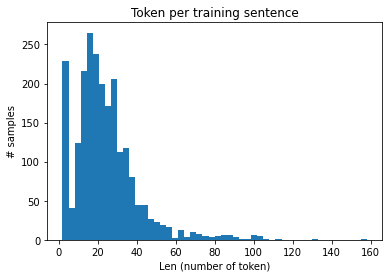

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in training_sentences], bins=50)
plt.title('Token per training sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

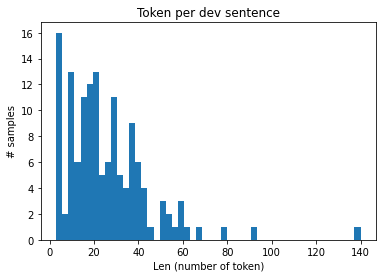

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in dev_sentences], bins=50)
plt.title('Token per dev sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

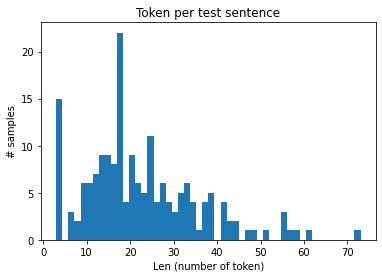

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in test_sentences], bins=50)
plt.title('Token per test sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

In [ ]:
# Keras (and most other ML packages) expect all the ids to be numeric, 
# this is an optimisation to save memory. 
# We will create the following dictionaries:
# word2idx: assign a numeric index to each word in the dataset
# idx2word: inverted version of word2idx
# tag2idx: assign a numeric index to each tag in the dataset
# idx2tag: inverted version of tag2idx

# Group training, dev and test data in order to create word-index dicts and to
# convert data to numeric indeces later
data = pd.concat([training_data, dev_data, test_data])

# words <= list of all words in the input dataset
words = list(set(data["Word"].values))
n_words = len(words)

# tags <= list of all tags in the input dataset
tags = []
for tag in set(data["Tag"].values):
    if tag is nan or isinstance(tag, float):
        tags.append('unk')
    else:
        tags.append(tag)
n_tags = len(tags)

# Dictionaries
word2idx = {w: i for i, w in enumerate(words)}
idx2word = {i: w for w, i in iteritems(word2idx)}
tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {v: k for k, v in iteritems(tag2idx)}

# Index number for the word 'ethanol'
print(word2idx['ethanol'])
# Word of index 10
print(idx2word[10])
# Index number for the tag 'B-Material'
print(tag2idx['B-Material'])
# Tag of index 4
print(idx2tag[4])

2018
Counter
16
I-Apparatus-Property-Type


In [ ]:
# Convert train, dev and test data to numeric values
X_train = [[word2idx[w[0]] for w in s] for s in training_sentences]
y_train = [[tag2idx[w[1]] for w in s] for s in training_sentences]

X_dev = [[word2idx[w[0]] for w in s] for s in dev_sentences]
y_dev = [[tag2idx[w[1]] for w in s] for s in dev_sentences]

X_test = [[word2idx[w[0]] for w in s] for s in test_sentences]
y_test = [[tag2idx[w[1]] for w in s] for s in test_sentences]

In [ ]:
# Use this function to randomly remove some points from training dataset
# Use removal percentage in decimal value. E.g.: if you set as 0.5, it will
# remove 50% of the dataset

def random_remove_data_points(dataset, labels, removal_percentage):
    if removal_percentage < 0 or removal_percentage > 1:
        raise Exception("Invalid removal percentage")
    
    if removal_percentage == 1:
        raise Exception("You can't remove the entire dataset")
    
    number_of_points_remaining = round(len(dataset)*(1-removal_percentage))

    try_again = True

    while try_again:
      random_idxs = np.random.choice(len(dataset), number_of_points_remaining, replace=False)
      cut_dataset_sentences = [dataset[i] for i in random_idxs]
      cut_dataset_labels = [labels[i] for i in random_idxs]
      cut_tags = list(set([idx2tag[j] for sub in cut_dataset_labels for j in sub]))

      if all(i in cut_tags for i in tags if i[:2] == "B-"):
        try_again = False

    return cut_dataset_sentences, cut_dataset_labels 

print(f"Points in X_train before removal: {len(X_train)}")
print(f"Points in y_train before removal: {len(y_train)}")
# X_train, y_train = random_remove_data_points(X_train, y_train, 0.95)
print(f"Points in X_train before removal: {len(X_train)}")
print(f"Points in y_train before removal: {len(y_train)}")

Points in X_train before removal: 2253
Points in y_train before removal: 2253
Points in X_train before removal: 2253
Points in y_train before removal: 2253


In [ ]:
# Aux functions to save data and dicts, if data consistency is important
# and there is desire to not random split again

def save_backup_dataset(dataset, filename):
  dataset_df = pd.DataFrame(dataset)
  dataset_df.to_csv(filename, index=False)
  gfile = drive.CreateFile({'parents': [{'id': BACKUP_FOLDER_ID}]})
  gfile.SetContentFile(filename)
  gfile.Upload()

def save_backup_dict(dict, filename):
  dict_file = open(filename, "wb")
  pickle.dump(dict, dict_file)
  dict_file.close()
  gfile = drive.CreateFile({'parents': [{'id': BACKUP_FOLDER_ID}]})
  gfile.SetContentFile(filename)
  gfile.Upload()

In [ ]:
# Uncomment this cell if you want to save data for further use

# Check some points before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['ethanol'])
print(idx2word[10])
print(tag2idx['B-Material'])
print(idx2tag[4])
print(n_words)
print(n_tags)

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

save_backup_dataset(X_train, X_train_filename)
save_backup_dataset(y_train, y_train_filename)
save_backup_dataset(X_dev, X_dev_filename)
save_backup_dataset(y_dev, y_dev_filename)
save_backup_dataset(X_test, X_test_filename)
save_backup_dataset(y_test, y_test_filename)

save_backup_dict(word2idx, word2idx_filename)
save_backup_dict(idx2word, idx2word_filename)
save_backup_dict(tag2idx, tag2idx_filename)
save_backup_dict(idx2tag, idx2tag_filename)

save_backup_dict({"n_words":n_words, "n_tags":n_tags}, others_filename)

[593, 940, 3950]
[35, 35, 35]
[593, 940, 4086]
[35, 35, 35]
[593, 940, 3454]
[35, 35, 35]
2018
Counter
16
I-Apparatus-Property-Type
6535
43


In [1]:
# Uncomment this cell if you want to load saved data

# Re-import necessary libs
import pandas as pd
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pickle, math
from requests import get
import numpy as np
import matplotlib.pyplot as plt
import random
import time
%tensorflow_version 2.x
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch import cuda
from torch.utils.data import Dataset, DataLoader
!pip install sentencepiece
!pip install transformers
from transformers import BertForTokenClassification, AutoTokenizer
import matplotlib.pyplot as plt
!pip install seqeval
from seqeval.metrics import f1_score, classification_report

BACKUP_FOLDER_ID = '1k9ffQhdSi8nv1s9hV8jNBguR4m4FIZWp'
notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

# Re-get important variables
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

def get_backup_files_ids(folder_id):
  file_list = drive.ListFile({'q': "'{}' in parents and trashed=false".format(folder_id)}).GetList()
  return file_list

def load_backup_dataset(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.csv")

  dataset = pd.read_csv(f"{file_id}.csv", encoding="latin1")
  dataset = dataset.values.tolist()
  dataset = [ [ int(word) for word in sentence if str(word) != 'nan' ] for sentence in dataset]
  return dataset

def load_backup_dict(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.pkl")

  dict_file = open(f"{file_id}.pkl", "rb")
  out_dict = pickle.load(dict_file)
  return out_dict

backup_file_list = get_backup_files_ids(BACKUP_FOLDER_ID)

X_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_train_filename][0]['id']
y_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_train_filename][0]['id']
X_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_dev_filename][0]['id']
y_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_dev_filename][0]['id']
X_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_test_filename][0]['id']
y_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_test_filename][0]['id']

word2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == word2idx_filename][0]['id']
idx2word_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2word_filename][0]['id']
tag2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == tag2idx_filename][0]['id']
idx2tag_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2tag_filename][0]['id']

others_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == others_filename][0]['id']

X_train = load_backup_dataset(X_train_file_id)
y_train = load_backup_dataset(y_train_file_id)
X_dev = load_backup_dataset(X_dev_file_id)
y_dev = load_backup_dataset(y_dev_file_id)
X_test = load_backup_dataset(X_test_file_id)
y_test = load_backup_dataset(y_test_file_id)

word2idx = load_backup_dict(word2idx_file_id)
idx2word = load_backup_dict(idx2word_file_id)
tag2idx = load_backup_dict(tag2idx_file_id)
idx2tag = load_backup_dict(idx2tag_file_id)

others = load_backup_dict(others_file_id)

n_words = others["n_words"]
n_tags = others["n_tags"]

# Check some points after loading data to see if they match the ones before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['ethanol'])
print(idx2word[10])
print(tag2idx['B-Material'])
print(idx2tag[4])
print(n_words)
print(n_tags)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 10.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 12.4 MB/s 
     |████████████████████████████████| 120 kB 60.7 MB/s 
     |████████████████████████████████| 6.6 MB 53.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 1.6 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=4604ddf772f867d63c277fbaf0a9f451d2f883fe52ed05183ce69716045a8bec
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval
[593, 940, 3950]
[35, 35, 35]
[593, 940, 4086]
[35, 35, 35

In [2]:
# Aux function to help in augmentation. Generates a dict where entities
# are the keys, and words are the values.

def create_entities_dict(dataset, labels, decoded_word=False):
    entities_dict = {}
    
    for i, sentence in enumerate(dataset):
        for k, word in enumerate(sentence):
            tag = idx2tag[labels[i][k]]
            if tag[:2] == "B-":
                if decoded_word:
                    word_list = [idx2word[word]]
                else:
                    word_list = [word]
                j = k + 1
                if j < len(labels[i]):
                    while idx2tag[labels[i][j]][:2] == "I-":
                        if decoded_word:
                            word_list.append(idx2word[dataset[i][j]])
                        else:
                            word_list.append(dataset[i][j])
                        j = j+1
                        if j == len(labels[i]):
                            break
                        
                if entities_dict.get(tag):
                    if word_list not in entities_dict[tag]:
                        entities_dict[tag].append(word_list)
                else:
                    entities_dict[tag] = [word_list]
                    
    return entities_dict

entities_dict = create_entities_dict(X_train, y_train)

In [3]:
# Augmentation function using entity replacement technique.
# It will generate a new dataset, with X% more points based on
# the original dataset. E.g.: if you set augmentation percentage as 0.5 and dataset has
# 1000 points, it will generate a dataset with 1500 points.

def generate_sentences(dataset, labels, entities_dict, augmented_set_size_percentage):
    if augmented_set_size_percentage < 0:
        raise Exception("Invalid augmented set size percentage")

    number_of_new_sentences = math.ceil(augmented_set_size_percentage * len(dataset))
    random_idxs = np.random.choice(len(dataset), number_of_new_sentences, replace=True)
    
    base_sequences = [dataset[i] for i in random_idxs]
    base_labels = [labels[i] for i in random_idxs]

    new_sequences = []
    new_labels = []
    
    for k, sequence in enumerate(base_sequences):
        new_sequence = []
        new_label = []

        for i, word in enumerate(sequence):
            tag = idx2tag[base_labels[k][i]]
            if tag == "O":
                new_sequence.append(word)
                new_label.append(base_labels[k][i])
            elif tag[:2] == "B-":
                same_entities_type_tmp = entities_dict[tag]
                same_entities_type = np.array(same_entities_type_tmp, dtype=object)
                random_entity_idx = np.random.choice(len(same_entities_type), 1)[0]
                random_entity = same_entities_type[random_entity_idx]
                random_number_of_tokens = random.randint(1, len(random_entity))
                random_entity_tokens = np.random.choice(random_entity, random_number_of_tokens, replace = False).tolist()
                entity = tag[2:]
                decoded_token_labels = [f"I-{entity}" for token in random_entity_tokens]
                decoded_token_labels[0] = tag
                encoded_token_labels = [tag2idx[label] for label in decoded_token_labels]
                new_sequence = new_sequence + random_entity_tokens
                new_label = new_label + encoded_token_labels

        new_sequences.append(new_sequence)
        new_labels.append(new_label)

    augmented_X_train = dataset + new_sequences
    augmented_y_train = labels + new_labels

    print(f"Points in X_train after augmentation: {len(augmented_X_train)}")
    print(f"Points in y_train after augmentation: {len(augmented_y_train)}")

    return augmented_X_train, augmented_y_train

In [4]:
tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")

class dataset(Dataset):
  def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

  def __getitem__(self, index):
        # step 1: get the sentence and word labels
        sentence = self.data.sentence[index]
        word_labels = self.data.word_labels[index].split(",") 

        # step 2: use tokenizer to encode sentence (includes padding/truncation up to max length)
        # BertTokenizerFast provides a handy "return_offsets_mapping" functionality for individual tokens
        encoding = self.tokenizer(sentence,
                             is_split_into_words=True,
                             return_offsets_mapping=True, 
                             padding='max_length', 
                             truncation=True, 
                             max_length=self.max_len)
        
        # step 3: create token labels only for first word pieces of each tokenized word
        labels = [tag2idx[label] for label in word_labels] 
        # code based on https://huggingface.co/transformers/custom_datasets.html#tok-ner
        # create an empty array of -100 of length max_length
        encoded_labels = np.ones(len(encoding["offset_mapping"]), dtype=int) * -100
        
        # set only labels whose first offset position is 0 and the second is not 0
        i = 0
        for idx, mapping in enumerate(encoding["offset_mapping"]):
          if mapping[0] == 0 and mapping[1] != 0:
            # overwrite label
            encoded_labels[idx] = labels[i]
            i += 1

        # step 4: turn everything into PyTorch tensors
        item = {key: torch.as_tensor(val) for key, val in encoding.items()}
        item['labels'] = torch.as_tensor(encoded_labels)
        
        return item

  def __len__(self):
        return self.len

In [5]:
# some configuration variables
LEARNING_RATE = 5e-05
MAX_GRAD_NORM = 10
TRAINING_STOP_LOSS_PERCENTAGE = 1

# Model creation function
def create_model(maxlen, n_labels, training_set, testing_set, validation_set):
  device = 'cuda' if cuda.is_available() else 'cpu'
  print("Device: ", device)

  model = BertForTokenClassification.from_pretrained('allenai/scibert_scivocab_uncased', num_labels=n_labels)
  model.to(device)

  optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

  TRAIN_BATCH_SIZE = round(0.05*len(training_set))
  if TRAIN_BATCH_SIZE > 32:
    TRAIN_BATCH_SIZE = 32
  if TRAIN_BATCH_SIZE < 10:
    TRAIN_BATCH_SIZE = 10

  VALID_BATCH_SIZE = round(0.1*len(validation_set))
  if VALID_BATCH_SIZE > 32:
    VALID_BATCH_SIZE = 32
  if VALID_BATCH_SIZE < 10:
    VALID_BATCH_SIZE = 10

  train_params = {'batch_size': TRAIN_BATCH_SIZE,
                  'shuffle': True,
                  'num_workers': 0
                  }

  test_params = {'batch_size': VALID_BATCH_SIZE,
                  'shuffle': True,
                  'num_workers': 0
                  }

  training_loader = DataLoader(training_set, **train_params)
  testing_loader = DataLoader(testing_set, **test_params)
  validation_loader = DataLoader(validation_set, **test_params)

  return model, device, optimizer, training_loader, testing_loader, validation_loader

In [6]:
# Model training function
def train(model, device, optimizer, training_loader, epoch, training_stop_loss_percentage):
    tr_loss, tr_accuracy = 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
    tr_preds, tr_labels = [], []
    losses = []
    # put model in training mode
    model.train()
    
    for idx, batch in enumerate(training_loader):
        
        ids = batch['input_ids'].to(device, dtype = torch.long)
        mask = batch['attention_mask'].to(device, dtype = torch.long)
        labels = batch['labels'].to(device, dtype = torch.long)

        loss, tr_logits = model(input_ids=ids, attention_mask=mask, labels=labels, return_dict = False)
        tr_loss += loss.item()

        nb_tr_steps += 1
        nb_tr_examples += labels.size(0)
        
        if idx % 100==0:
            loss_step = tr_loss/nb_tr_steps
            print(f"Training loss per 100 training steps: {loss_step}")
            losses.append(loss_step)
            last_5_losses = losses[-5:]
            loss_min = min(last_5_losses)
            loss_max = max(last_5_losses)
            if len(last_5_losses) > 1 and (loss_max - loss_min)/loss_max < training_stop_loss_percentage/100:
              print("Stopping epoch...")
              break
           
        # compute training accuracy
        flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
        active_logits = tr_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
        flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
        
        # only compute accuracy at active labels
        active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        #active_labels = torch.where(active_accuracy, labels.view(-1), torch.tensor(-100).type_as(labels))
        
        labels = torch.masked_select(flattened_targets, active_accuracy)
        predictions = torch.masked_select(flattened_predictions, active_accuracy)
        
        tr_labels.extend(labels)
        tr_preds.extend(predictions)

        tmp_tr_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
        tr_accuracy += tmp_tr_accuracy
    
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=MAX_GRAD_NORM
        )
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = tr_loss / nb_tr_steps
    tr_accuracy = tr_accuracy / nb_tr_steps
    print(f"Training loss epoch: {epoch_loss}")
    print(f"Training accuracy epoch: {tr_accuracy}")

In [7]:
# Model testing function
def test(model, device, testing_loader):
    print("Validating model...")
    # put model in evaluation mode
    model.eval()
    
    eval_loss, eval_accuracy = 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    eval_preds, eval_labels = [], []
    
    with torch.no_grad():
        for idx, batch in enumerate(testing_loader):
            
            ids = batch['input_ids'].to(device, dtype = torch.long)
            mask = batch['attention_mask'].to(device, dtype = torch.long)
            labels = batch['labels'].to(device, dtype = torch.long)
            
            loss, eval_logits = model(input_ids=ids, attention_mask=mask, labels=labels, return_dict = False)
            
            eval_loss += loss.item()

            nb_eval_steps += 1
            nb_eval_examples += labels.size(0)
        
            # compute evaluation accuracy
            flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
            active_logits = eval_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
            
            # only compute accuracy at active labels
            active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        
            labels = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)
            
            eval_labels.extend(labels)
            eval_preds.extend(predictions)
            
            tmp_eval_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
            eval_accuracy += tmp_eval_accuracy

    labels = [idx2tag[id.item()] for id in eval_labels]
    predictions = [idx2tag[id.item()] for id in eval_preds]
    
    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_steps
    print(f"Validation Loss: {eval_loss}")
    print(f"Validation Accuracy: {eval_accuracy}")

    return labels, predictions, eval_loss

In [8]:
def create_train_and_validate_model(augmented_percentage):

  augmented_X_train, augmented_y_train = generate_sentences(X_train, y_train, entities_dict, augmented_percentage)

  maxlen_X_train = max([len(s) for s in augmented_X_train])
  maxlen_X_test = max([len(s) for s in X_test])
  maxlen_X_dev = max([len(s) for s in X_dev])
  maxlen_y_train = max([len(s) for s in augmented_y_train])
  maxlen_y_test = max([len(s) for s in y_test])
  maxlen_y_dev = max([len(s) for s in y_dev])

  maxlen = max([maxlen_X_train, maxlen_X_test, maxlen_X_dev, maxlen_y_train, maxlen_y_test, maxlen_y_dev])

  augmented_X_train_words = [[idx2word[word] for word in sentence] for sentence in augmented_X_train]
  X_dev_words = [[idx2word[word] for word in sentence] for sentence in X_dev]
  X_test_words = [[idx2word[word] for word in sentence] for sentence in X_test]
  augmented_y_train_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in augmented_y_train]
  y_dev_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in y_dev]
  y_test_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in y_test]

  new_train_df = pd.DataFrame({"sentence": augmented_X_train_words, "word_labels": augmented_y_train_tags}).reset_index(drop=True)
  new_test_df = pd.DataFrame({"sentence": X_test_words, "word_labels": y_test_tags}).reset_index(drop=True)
  new_val_df = pd.DataFrame({"sentence": X_dev_words, "word_labels": y_dev_tags}).reset_index(drop=True)

  training_set = dataset(new_train_df, tokenizer, maxlen)
  testing_set = dataset(new_test_df, tokenizer, maxlen)
  validation_set = dataset(new_val_df, tokenizer, maxlen)

  model, device, optimizer, training_loader, testing_loader, val_loader = create_model(maxlen, len(tag2idx), training_set, testing_set, validation_set)

  training_start_time = time.clock()
  min_val_loss = 0
  MAX_PATIENCE = 5
  patience = 0

  for epoch in range(100):
    print(f"Training epoch: {epoch + 1}")
    if patience == MAX_PATIENCE:
      print("Patience limit reached")
      break
    train(model, device, optimizer, training_loader, epoch, TRAINING_STOP_LOSS_PERCENTAGE)
    labels, predictions, val_loss = test(model, device, val_loader)
    if ((min_val_loss == 0) or (min_val_loss != 0 and val_loss < min_val_loss)):
      min_val_loss = val_loss
      torch.save(model.state_dict(), 'checkpoint.pt')
      patience = 0
    else:
      patience = patience + 1
  print(f"Training duration: {(time.clock() - training_start_time)/60} minutes")

  checkpoint = torch.load('checkpoint.pt')
  model.load_state_dict(checkpoint)

  validation_start_time = time.clock()
  labels, predictions, test_loss = test(model, device, testing_loader)
  labels = [labels]
  predictions = [predictions]
  print(f"Validation duration: {(time.clock() - validation_start_time)/60} minutes")

  print("F1-score (test): {:.1%}".format(f1_score(labels, predictions)))
  print(classification_report(labels, predictions))

In [9]:
number_of_training_models = 10
target_augmented_percentage = 0

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 2253
Points in y_train after augmentation: 2253
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.792036294937134
Training loss epoch: 0.9149761346864028
Training accuracy epoch: 0.7790989432553598
Validating model...
Validation Loss: 0.5103547126054764
Validation Accuracy: 0.8559738313286648
Training epoch: 2
Training loss per 100 training steps: 0.3508283495903015
Training loss epoch: 0.36650426580872336
Training accuracy epoch: 0.8888173572262799
Validating model...
Validation Loss: 0.42090944945812225
Validation Accuracy: 0.865746121043591
Training epoch: 3
Training loss per 100 training steps: 0.2628245949745178
Training loss epoch: 0.2529337307516958
Training accuracy epoch: 0.9185888039605729
Validating model...
Validation Loss: 0.4202223628759384
Validation Accuracy: 0.8705021133632236
Training epoch: 4
Training loss per 100 training steps: 0.17690806090831757
Training loss epoch: 0.18404048523852523
Training accuracy epoch: 0.9400680329815856
Validating model...
Validation Loss: 0.49602876603603363
Validation Accura

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4424142814599551
Validation Accuracy: 0.8590108059032706
Validation duration: 0.011859333333333192 minutes
F1-score (test): 78.0%
                            precision    recall  f1-score   support

               Amount-Misc       0.22      0.29      0.25         7
               Amount-Unit       0.96      0.94      0.95        98
      Apparatus-Descriptor       0.36      0.44      0.40         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.70      0.54      0.61        13
                     Brand       0.65      0.81      0.72        27
Characterization-Apparatus       0.09      0.09      0.09        11
            Condition-Misc       0.53      0.90      0.67        20
            Condition-Type       0.06      1.00      0.11         1
            Condition-Unit       0.92      0.98      0.95        87
                  Material       0.76      0.88      0.81       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.8089981079101562
Training loss epoch: 0.8960978418168887
Training accuracy epoch: 0.7851369669121708
Validating model...
Validation Loss: 0.4981928259134293
Validation Accuracy: 0.8528318824520597
Training epoch: 2
Training loss per 100 training steps: 0.40558966994285583
Training loss epoch: 0.35747552085930195
Training accuracy epoch: 0.8901440979933918
Validating model...
Validation Loss: 0.41543183028697966
Validation Accuracy: 0.873756919832536
Training epoch: 3
Training loss per 100 training steps: 0.23316271603107452
Training loss epoch: 0.2544478577837138
Training accuracy epoch: 0.9171377720869434
Validating model...
Validation Loss: 0.4442713916301727
Validation Accuracy: 0.8702538659384859
Training epoch: 4
Training loss per 100 training steps: 0.16700933873653412
Training loss epoch: 0.1829178704762123
Training accuracy epoch: 0.940555968704596
Validating model...
Validation Loss: 0.41392993479967116
Validation Accur

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4467290479403276
Validation Accuracy: 0.8682940116953516
Validation duration: 0.01178229999999966 minutes
F1-score (test): 79.6%
                            precision    recall  f1-score   support

               Amount-Misc       0.25      0.43      0.32         7
               Amount-Unit       0.97      0.95      0.96        98
      Apparatus-Descriptor       0.54      0.78      0.64         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.67      0.46      0.55        13
                     Brand       0.67      0.81      0.73        27
Characterization-Apparatus       0.18      0.18      0.18        11
            Condition-Misc       0.56      1.00      0.71        20
            Condition-Type       0.05      1.00      0.09         1
            Condition-Unit       0.91      0.98      0.94        87
                  Material       0.78      0.86      0.82       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from th

Training epoch: 1
Training loss per 100 training steps: 3.93856143951416
Training loss epoch: 0.9194407819862097
Training accuracy epoch: 0.7796130559219157
Validating model...
Validation Loss: 0.4942066460847855
Validation Accuracy: 0.8603790931996139
Training epoch: 2
Training loss per 100 training steps: 0.3559143841266632
Training loss epoch: 0.36800130110391427
Training accuracy epoch: 0.8878908091631658
Validating model...
Validation Loss: 0.43627375066280366
Validation Accuracy: 0.8736849123627536
Training epoch: 3
Training loss per 100 training steps: 0.24725376069545746
Training loss epoch: 0.2691964498707946
Training accuracy epoch: 0.9136145930323225
Validating model...
Validation Loss: 0.3993706345558167
Validation Accuracy: 0.8769944760686215
Training epoch: 4
Training loss per 100 training steps: 0.23276852071285248
Training loss epoch: 0.18672993401406515
Training accuracy epoch: 0.9385399699723144
Validating model...
Validation Loss: 0.4065307557582855
Validation Accura

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4543008781396426
Validation Accuracy: 0.8648032024749459
Validation duration: 0.011887733333333017 minutes
F1-score (test): 79.6%
                            precision    recall  f1-score   support

               Amount-Misc       0.23      0.43      0.30         7
               Amount-Unit       0.92      0.95      0.93        98
      Apparatus-Descriptor       0.58      0.78      0.67         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.70      0.54      0.61        13
                     Brand       0.71      0.81      0.76        27
Characterization-Apparatus       1.00      0.09      0.17        11
            Condition-Misc       0.57      1.00      0.73        20
            Condition-Type       0.08      1.00      0.15         1
            Condition-Unit       0.93      0.98      0.96        87
                  Material       0.75      0.91      0.82       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.9017844200134277
Training loss epoch: 0.8807769862698837
Training accuracy epoch: 0.7879839004582677
Validating model...
Validation Loss: 0.4542814001441002
Validation Accuracy: 0.8731365013682657
Training epoch: 2
Training loss per 100 training steps: 0.3667934536933899
Training loss epoch: 0.3662079568480102
Training accuracy epoch: 0.8897502393237076
Validating model...
Validation Loss: 0.4947289824485779
Validation Accuracy: 0.8735034804357898
Training epoch: 3
Training loss per 100 training steps: 0.4461418092250824
Training loss epoch: 0.2575963546692486
Training accuracy epoch: 0.9185933819625662
Validating model...
Validation Loss: 0.42998839914798737
Validation Accuracy: 0.8745319578055538
Training epoch: 4
Training loss per 100 training steps: 0.1574336737394333
Training loss epoch: 0.18158503443422452
Training accuracy epoch: 0.9414354647617603
Validating model...
Validation Loss: 0.4185221567749977
Validation Accurac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4709370674995276
Validation Accuracy: 0.8618059403234687
Validation duration: 0.012357116666667405 minutes
F1-score (test): 80.2%
                            precision    recall  f1-score   support

               Amount-Misc       0.23      0.43      0.30         7
               Amount-Unit       0.97      0.96      0.96        98
      Apparatus-Descriptor       0.57      0.89      0.70         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.80      0.31      0.44        13
                     Brand       0.78      0.78      0.78        27
Characterization-Apparatus       0.25      0.09      0.13        11
            Condition-Misc       0.62      1.00      0.77        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.92      0.95      0.94        87
                  Material       0.76      0.89      0.82       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.8008716106414795
Training loss epoch: 0.8952898253017748
Training accuracy epoch: 0.7831205281650768
Validating model...
Validation Loss: 0.49516492187976835
Validation Accuracy: 0.8524838313964281
Training epoch: 2
Training loss per 100 training steps: 0.3990561366081238
Training loss epoch: 0.3626866743598186
Training accuracy epoch: 0.8883788150672746
Validating model...
Validation Loss: 0.45568552911281585
Validation Accuracy: 0.8547721594557869
Training epoch: 3
Training loss per 100 training steps: 0.22837702929973602
Training loss epoch: 0.2484171277200672
Training accuracy epoch: 0.9187399958523745
Validating model...
Validation Loss: 0.4406704977154732
Validation Accuracy: 0.8641697436757697
Training epoch: 4
Training loss per 100 training steps: 0.17299619317054749
Training loss epoch: 0.17601920422953618
Training accuracy epoch: 0.9435433663405707
Validating model...
Validation Loss: 0.4706308841705322
Validation Accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4816199907889733
Validation Accuracy: 0.8504261709756356
Validation duration: 0.011685266666667833 minutes
F1-score (test): 78.2%
                            precision    recall  f1-score   support

               Amount-Misc       0.27      0.43      0.33         7
               Amount-Unit       0.93      0.92      0.92        98
      Apparatus-Descriptor       0.57      0.89      0.70         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.62      0.38      0.48        13
                     Brand       0.72      0.85      0.78        27
Characterization-Apparatus       0.25      0.09      0.13        11
            Condition-Misc       0.47      0.95      0.63        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.91      0.97      0.94        87
                  Material       0.77      0.89      0.82       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.825162887573242
Training loss epoch: 0.913865714006021
Training accuracy epoch: 0.7833138462690107
Validating model...
Validation Loss: 0.4676631331443787
Validation Accuracy: 0.8674488244655952
Training epoch: 2
Training loss per 100 training steps: 0.34877651929855347
Training loss epoch: 0.36442450045699804
Training accuracy epoch: 0.8902115990532219
Validating model...
Validation Loss: 0.40777380764484406
Validation Accuracy: 0.8721770710131086
Training epoch: 3
Training loss per 100 training steps: 0.28355923295021057
Training loss epoch: 0.255204202843384
Training accuracy epoch: 0.9176674516459524
Validating model...
Validation Loss: 0.4035586938261986
Validation Accuracy: 0.8712297507920646
Training epoch: 4
Training loss per 100 training steps: 0.24624358117580414
Training loss epoch: 0.1792955954729671
Training accuracy epoch: 0.9427658427162969
Validating model...
Validation Loss: 0.4490268677473068
Validation Accurac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4389510200573848
Validation Accuracy: 0.8637566101511376
Validation duration: 0.012281133333336433 minutes
F1-score (test): 79.4%
                            precision    recall  f1-score   support

               Amount-Misc       0.29      0.29      0.29         7
               Amount-Unit       0.91      0.92      0.91        98
      Apparatus-Descriptor       0.50      0.89      0.64         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.57      0.31      0.40        13
                     Brand       0.69      0.81      0.75        27
Characterization-Apparatus       0.40      0.18      0.25        11
            Condition-Misc       0.51      1.00      0.68        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.91      0.98      0.94        87
                  Material       0.76      0.88      0.82       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.9085028171539307
Training loss epoch: 0.9012659658008898
Training accuracy epoch: 0.7846452123074418
Validating model...
Validation Loss: 0.4994111299514771
Validation Accuracy: 0.8593838393832176
Training epoch: 2
Training loss per 100 training steps: 0.44297489523887634
Training loss epoch: 0.3660712309286628
Training accuracy epoch: 0.8897393010329564
Validating model...
Validation Loss: 0.41497263610363005
Validation Accuracy: 0.8688102482244803
Training epoch: 3
Training loss per 100 training steps: 0.2683661878108978
Training loss epoch: 0.2590009693948316
Training accuracy epoch: 0.9151793602663358
Validating model...
Validation Loss: 0.4461349442601204
Validation Accuracy: 0.8661151829522916
Training epoch: 4
Training loss per 100 training steps: 0.21983709931373596
Training loss epoch: 0.1848938984560295
Training accuracy epoch: 0.9394788920477204
Validating model...
Validation Loss: 0.44517792463302613
Validation Accur

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4496405766560481
Validation Accuracy: 0.860939583057102
Validation duration: 0.011845416666665188 minutes
F1-score (test): 79.6%
                            precision    recall  f1-score   support

               Amount-Misc       0.38      0.43      0.40         7
               Amount-Unit       0.89      0.95      0.92        98
      Apparatus-Descriptor       0.41      0.78      0.54         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.67      0.31      0.42        13
                     Brand       0.71      0.81      0.76        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.71      1.00      0.83        20
            Condition-Type       0.14      1.00      0.25         1
            Condition-Unit       0.89      0.94      0.92        87
                  Material       0.75      0.91      0.82       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.822948455810547
Training loss epoch: 0.9040449312035467
Training accuracy epoch: 0.7844862565739474
Validating model...
Validation Loss: 0.467393746972084
Validation Accuracy: 0.8674226455293386
Training epoch: 2
Training loss per 100 training steps: 0.38845086097717285
Training loss epoch: 0.36224745486823606
Training accuracy epoch: 0.890641135027207
Validating model...
Validation Loss: 0.39957543909549714
Validation Accuracy: 0.8693872015735783
Training epoch: 3
Training loss per 100 training steps: 0.258965402841568
Training loss epoch: 0.24734126891888364
Training accuracy epoch: 0.920989483526346
Validating model...
Validation Loss: 0.425613172352314
Validation Accuracy: 0.8677105570905619
Training epoch: 4
Training loss per 100 training steps: 0.1666816920042038
Training loss epoch: 0.17534512365368052
Training accuracy epoch: 0.9444085681752571
Validating model...
Validation Loss: 0.4085982501506805
Validation Accuracy: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.48229033671892607
Validation Accuracy: 0.8518065857362951
Validation duration: 0.011854716666668234 minutes
F1-score (test): 78.4%
                            precision    recall  f1-score   support

               Amount-Misc       0.27      0.43      0.33         7
               Amount-Unit       0.89      0.95      0.92        98
      Apparatus-Descriptor       0.75      0.67      0.71         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.83      0.38      0.53        13
                     Brand       0.65      0.81      0.72        27
Characterization-Apparatus       0.50      0.09      0.15        11
            Condition-Misc       0.58      0.95      0.72        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.90      0.98      0.94        87
                  Material       0.73      0.90      0.80       316
       Materi

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.7189221382141113
Training loss epoch: 0.8953115881328851
Training accuracy epoch: 0.785600804010176
Validating model...
Validation Loss: 0.4684914082288742
Validation Accuracy: 0.8678945182276824
Training epoch: 2
Training loss per 100 training steps: 0.3921974003314972
Training loss epoch: 0.3571208975684475
Training accuracy epoch: 0.8920521521385468
Validating model...
Validation Loss: 0.39453389048576354
Validation Accuracy: 0.8768822430029347
Training epoch: 3
Training loss per 100 training steps: 0.26877498626708984
Training loss epoch: 0.24738367594463725
Training accuracy epoch: 0.9200094480741074
Validating model...
Validation Loss: 0.423467181622982
Validation Accuracy: 0.8680165049513565
Training epoch: 4
Training loss per 100 training steps: 0.1265181303024292
Training loss epoch: 0.169777689370471
Training accuracy epoch: 0.9450095088821613
Validating model...
Validation Loss: 0.47438002973794935
Validation Accuracy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.45089861292105454
Validation Accuracy: 0.8573744603320405
Validation duration: 0.011850199999999707 minutes
F1-score (test): 78.8%
                            precision    recall  f1-score   support

               Amount-Misc       0.27      0.43      0.33         7
               Amount-Unit       0.93      0.95      0.94        98
      Apparatus-Descriptor       0.67      0.67      0.67         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.57      0.31      0.40        13
                     Brand       0.74      0.85      0.79        27
Characterization-Apparatus       0.50      0.09      0.15        11
            Condition-Misc       0.50      0.95      0.66        20
            Condition-Type       0.17      1.00      0.29         1
            Condition-Unit       0.92      0.97      0.94        87
                  Material       0.76      0.87      0.81       316
       Materi

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.9909658432006836
Training loss epoch: 0.9091924311409534
Training accuracy epoch: 0.784594136637094
Validating model...
Validation Loss: 0.535515296459198
Validation Accuracy: 0.844598461060313
Training epoch: 2
Training loss per 100 training steps: 0.40628311038017273
Training loss epoch: 0.36490387501011434
Training accuracy epoch: 0.8884928796750539
Validating model...
Validation Loss: 0.4384461522102356
Validation Accuracy: 0.863786836020215
Training epoch: 3
Training loss per 100 training steps: 0.2493489384651184
Training loss epoch: 0.2492981729373126
Training accuracy epoch: 0.9197349074888236
Validating model...
Validation Loss: 0.42720135748386384
Validation Accuracy: 0.8682703517056843
Training epoch: 4
Training loss per 100 training steps: 0.17343340814113617
Training loss epoch: 0.17873857159849624
Training accuracy epoch: 0.942245449416349
Validating model...
Validation Loss: 0.46303053945302963
Validation Accuracy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4545600483050713
Validation Accuracy: 0.8592020564485211
Validation duration: 0.012440333333332394 minutes
F1-score (test): 78.5%
                            precision    recall  f1-score   support

               Amount-Misc       0.27      0.43      0.33         7
               Amount-Unit       0.91      0.96      0.94        98
      Apparatus-Descriptor       0.42      0.89      0.57         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.64      0.54      0.58        13
                     Brand       0.70      0.85      0.77        27
Characterization-Apparatus       0.33      0.09      0.14        11
            Condition-Misc       0.53      0.95      0.68        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.93      0.97      0.95        87
                  Material       0.77      0.87      0.82       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [10]:
number_of_training_models = 10
target_augmented_percentage = 0.25

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 25.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 2817
Points in y_train after augmentation: 2817
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.8918113708496094
Training loss epoch: 0.8514160118745954
Training accuracy epoch: 0.7912147717470486
Validating model...
Validation Loss: 0.47714920341968536
Validation Accuracy: 0.8604214917198497
Training epoch: 2
Training loss per 100 training steps: 0.3852960765361786
Training loss epoch: 0.3548007376408309
Training accuracy epoch: 0.8921109414096547
Validating model...
Validation Loss: 0.4154993459582329
Validation Accuracy: 0.8740284006420012
Training epoch: 3
Training loss per 100 training steps: 0.20662541687488556
Training loss epoch: 0.24002124419373072
Training accuracy epoch: 0.9239199654963645
Validating model...
Validation Loss: 0.3832767724990845
Validation Accuracy: 0.8843507653887563
Training epoch: 4
Training loss per 100 training steps: 0.16789524257183075
Training loss epoch: 0.16667391259348793
Training accuracy epoch: 0.9471961499471455
Validating model...
Validation Loss: 0.42226665616035464
Validation Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4409453204044929
Validation Accuracy: 0.8647770341316294
Validation duration: 0.011957433333335151 minutes
F1-score (test): 79.1%
                            precision    recall  f1-score   support

               Amount-Misc       0.27      0.43      0.33         7
               Amount-Unit       0.90      0.94      0.92        98
      Apparatus-Descriptor       0.50      0.78      0.61         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.67      0.31      0.42        13
                     Brand       0.64      0.78      0.70        27
Characterization-Apparatus       0.33      0.09      0.14        11
            Condition-Misc       0.62      0.90      0.73        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.91      0.97      0.94        87
                  Material       0.78      0.86      0.82       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 2817
Points in y_train after augmentation: 2817
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.756051540374756
Training loss epoch: 0.8283959026919322
Training accuracy epoch: 0.7966326112975538
Validating model...
Validation Loss: 0.47024814784526825
Validation Accuracy: 0.8675361599895972
Training epoch: 2
Training loss per 100 training steps: 0.43855783343315125
Training loss epoch: 0.35566155763154617
Training accuracy epoch: 0.8904938513842863
Validating model...
Validation Loss: 0.4250693112611771
Validation Accuracy: 0.8704631327760872
Training epoch: 3
Training loss per 100 training steps: 0.28601714968681335
Training loss epoch: 0.25044117934918136
Training accuracy epoch: 0.9189175843926084
Validating model...
Validation Loss: 0.4046190470457077
Validation Accuracy: 0.8768530148642368
Training epoch: 4
Training loss per 100 training steps: 0.18208253383636475
Training loss epoch: 0.16907099148865495
Training accuracy epoch: 0.9449601533130187
Validating model...
Validation Loss: 0.42548991143703463
Validation Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.46328363854151505
Validation Accuracy: 0.8590918824803244
Validation duration: 0.011701650000001488 minutes
F1-score (test): 78.6%
                            precision    recall  f1-score   support

               Amount-Misc       0.33      0.43      0.38         7
               Amount-Unit       0.85      0.92      0.88        98
      Apparatus-Descriptor       0.44      0.78      0.56         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.56      0.38      0.45        13
                     Brand       0.66      0.78      0.71        27
Characterization-Apparatus       0.25      0.18      0.21        11
            Condition-Misc       0.54      1.00      0.70        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.91      0.98      0.94        87
                  Material       0.75      0.90      0.82       316
       Materi

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 2817
Points in y_train after augmentation: 2817
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.8980066776275635
Training loss epoch: 0.8272337016094936
Training accuracy epoch: 0.7947403456184831
Validating model...
Validation Loss: 0.4792321056127548
Validation Accuracy: 0.8601828513699257
Training epoch: 2
Training loss per 100 training steps: 0.49947988986968994
Training loss epoch: 0.3630597839194737
Training accuracy epoch: 0.8887664194327867
Validating model...
Validation Loss: 0.4065054148435593
Validation Accuracy: 0.8743784752259887
Training epoch: 3
Training loss per 100 training steps: 0.2131522297859192
Training loss epoch: 0.24890567094422458
Training accuracy epoch: 0.9207722511177223
Validating model...
Validation Loss: 0.42133891582489014
Validation Accuracy: 0.8771743021042434
Training epoch: 4
Training loss per 100 training steps: 0.23185114562511444
Training loss epoch: 0.17178201867958134
Training accuracy epoch: 0.9446205611699128
Validating model...
Validation Loss: 0.43879796415567396
Validation Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4839700414584233
Validation Accuracy: 0.84894752423643
Validation duration: 0.011930433333327528 minutes
F1-score (test): 78.4%
                            precision    recall  f1-score   support

               Amount-Misc       0.23      0.43      0.30         7
               Amount-Unit       0.92      0.94      0.93        98
      Apparatus-Descriptor       0.50      0.67      0.57         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.67      0.46      0.55        13
                     Brand       0.67      0.89      0.76        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.45      0.95      0.61        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.89      0.98      0.93        87
                  Material       0.76      0.91      0.83       316
       Material-

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 2817
Points in y_train after augmentation: 2817
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.9727025032043457
Training loss epoch: 0.8481270181998778
Training accuracy epoch: 0.7954240358109103
Validating model...
Validation Loss: 0.43890911936759947
Validation Accuracy: 0.8743454616948716
Training epoch: 2
Training loss per 100 training steps: 0.45419129729270935
Training loss epoch: 0.3486946983618683
Training accuracy epoch: 0.8929848667065226
Validating model...
Validation Loss: 0.4262066215276718
Validation Accuracy: 0.8670501526372479
Training epoch: 3
Training loss per 100 training steps: 0.27521875500679016
Training loss epoch: 0.24388089558381712
Training accuracy epoch: 0.9227060309946821
Validating model...
Validation Loss: 0.4532675050199032
Validation Accuracy: 0.8701828535805802
Training epoch: 4
Training loss per 100 training steps: 0.2822187840938568
Training loss epoch: 0.18820800355980905
Training accuracy epoch: 0.9415849819943777
Validating model...
Validation Loss: 0.4543545126914978
Validation Accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4725148838299971
Validation Accuracy: 0.8526784790702568
Validation duration: 0.011854583333335238 minutes
F1-score (test): 77.8%
                            precision    recall  f1-score   support

               Amount-Misc       0.18      0.29      0.22         7
               Amount-Unit       0.96      0.94      0.95        98
      Apparatus-Descriptor       0.36      0.89      0.52         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.75      0.46      0.57        13
                     Brand       0.63      0.81      0.71        27
Characterization-Apparatus       0.50      0.18      0.27        11
            Condition-Misc       0.53      0.95      0.68        20
            Condition-Type       0.05      1.00      0.10         1
            Condition-Unit       0.92      0.98      0.95        87
                  Material       0.74      0.90      0.81       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 2817
Points in y_train after augmentation: 2817
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 4.0710625648498535
Training loss epoch: 0.8515924088070902
Training accuracy epoch: 0.7935765603143702
Validating model...
Validation Loss: 0.46642431765794756
Validation Accuracy: 0.8628430707084753
Training epoch: 2
Training loss per 100 training steps: 0.3549850285053253
Training loss epoch: 0.35032856079299796
Training accuracy epoch: 0.8930057680267054
Validating model...
Validation Loss: 0.3943796992301941
Validation Accuracy: 0.8721696514111086
Training epoch: 3
Training loss per 100 training steps: 0.15911734104156494
Training loss epoch: 0.24015597036380446
Training accuracy epoch: 0.923530330549077
Validating model...
Validation Loss: 0.4182408392429352
Validation Accuracy: 0.865810417159732
Training epoch: 4
Training loss per 100 training steps: 0.14500588178634644
Training loss epoch: 0.16634770367671264
Training accuracy epoch: 0.9467071244641833
Validating model...
Validation Loss: 0.4616875484585762
Validation Accur

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4590417673954597
Validation Accuracy: 0.8519118954529799
Validation duration: 0.011788916666667622 minutes
F1-score (test): 77.3%
                            precision    recall  f1-score   support

               Amount-Misc       0.27      0.43      0.33         7
               Amount-Unit       0.92      0.93      0.92        98
      Apparatus-Descriptor       0.58      0.78      0.67         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.50      0.31      0.38        13
                     Brand       0.68      0.78      0.72        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.54      0.95      0.69        20
            Condition-Type       0.07      1.00      0.13         1
            Condition-Unit       0.92      0.99      0.96        87
                  Material       0.75      0.85      0.80       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 2817
Points in y_train after augmentation: 2817
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 4.141849994659424
Training loss epoch: 0.8758872837832804
Training accuracy epoch: 0.7863914962563348
Validating model...
Validation Loss: 0.4826453685760498
Validation Accuracy: 0.8597811344463879
Training epoch: 2
Training loss per 100 training steps: 0.4273054003715515
Training loss epoch: 0.351572249712569
Training accuracy epoch: 0.8926219009128304
Validating model...
Validation Loss: 0.456142920255661
Validation Accuracy: 0.8590074190589068
Training epoch: 3
Training loss per 100 training steps: 0.32158923149108887
Training loss epoch: 0.2443222189217471
Training accuracy epoch: 0.9207601719023564
Validating model...
Validation Loss: 0.4483325511217117
Validation Accuracy: 0.8713145563346689
Training epoch: 4
Training loss per 100 training steps: 0.19758333265781403
Training loss epoch: 0.1703546672557177
Training accuracy epoch: 0.9456974995697293
Validating model...
Validation Loss: 0.4108894392848015
Validation Accuracy: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4766710859078627
Validation Accuracy: 0.8585867797756611
Validation duration: 0.011792266666672428 minutes
F1-score (test): 78.2%
                            precision    recall  f1-score   support

               Amount-Misc       0.25      0.43      0.32         7
               Amount-Unit       0.93      0.92      0.92        98
      Apparatus-Descriptor       0.53      0.89      0.67         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.71      0.38      0.50        13
                     Brand       0.68      0.85      0.75        27
Characterization-Apparatus       0.29      0.18      0.22        11
            Condition-Misc       0.49      0.95      0.64        20
            Condition-Type       0.06      1.00      0.12         1
            Condition-Unit       0.89      0.99      0.93        87
                  Material       0.76      0.85      0.81       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 2817
Points in y_train after augmentation: 2817
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.973367691040039
Training loss epoch: 0.8320279920034195
Training accuracy epoch: 0.7930968838414317
Validating model...
Validation Loss: 0.4662320762872696
Validation Accuracy: 0.8668784232703652
Training epoch: 2
Training loss per 100 training steps: 0.6028374433517456
Training loss epoch: 0.34771546721458435
Training accuracy epoch: 0.8927078952082169
Validating model...
Validation Loss: 0.40722000896930693
Validation Accuracy: 0.8764110295372965
Training epoch: 3
Training loss per 100 training steps: 0.2603994905948639
Training loss epoch: 0.24018961760435212
Training accuracy epoch: 0.9236364355252483
Validating model...
Validation Loss: 0.40640026330947876
Validation Accuracy: 0.8786035946693522
Training epoch: 4
Training loss per 100 training steps: 0.15160460770130157
Training loss epoch: 0.16863046569770643
Training accuracy epoch: 0.9471043139943538
Validating model...
Validation Loss: 0.40871008336544035
Validation Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.46029428793833804
Validation Accuracy: 0.8557875123831035
Validation duration: 0.013263133333331704 minutes
F1-score (test): 77.8%
                            precision    recall  f1-score   support

               Amount-Misc       0.38      0.71      0.50         7
               Amount-Unit       0.95      0.94      0.94        98
      Apparatus-Descriptor       0.32      0.67      0.43         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.60      0.46      0.52        13
                     Brand       0.74      0.85      0.79        27
Characterization-Apparatus       0.33      0.36      0.35        11
            Condition-Misc       0.54      1.00      0.70        20
            Condition-Type       0.08      1.00      0.14         1
            Condition-Unit       0.90      0.98      0.94        87
                  Material       0.72      0.88      0.79       316
       Materi

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 2817
Points in y_train after augmentation: 2817
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.805137872695923
Training loss epoch: 0.8497072829959098
Training accuracy epoch: 0.7938968268255377
Validating model...
Validation Loss: 0.49125838577747344
Validation Accuracy: 0.8573681156572878
Training epoch: 2
Training loss per 100 training steps: 0.32234326004981995
Training loss epoch: 0.35698852361587996
Training accuracy epoch: 0.8912374638304674
Validating model...
Validation Loss: 0.3834675312042236
Validation Accuracy: 0.880369946197175
Training epoch: 3
Training loss per 100 training steps: 0.3150252103805542
Training loss epoch: 0.2454581791430377
Training accuracy epoch: 0.9203742615748531
Validating model...
Validation Loss: 0.40344850420951844
Validation Accuracy: 0.874088755872379
Training epoch: 4
Training loss per 100 training steps: 0.14720191061496735
Training loss epoch: 0.17293375812136055
Training accuracy epoch: 0.9448093462955878
Validating model...
Validation Loss: 0.4367175787687302
Validation Accura

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4426953150675847
Validation Accuracy: 0.8572169563493628
Validation duration: 0.011594849999998285 minutes
F1-score (test): 78.2%
                            precision    recall  f1-score   support

               Amount-Misc       0.25      0.43      0.32         7
               Amount-Unit       0.87      0.94      0.90        98
      Apparatus-Descriptor       0.47      0.89      0.62         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.64      0.54      0.58        13
                     Brand       0.55      0.67      0.60        27
Characterization-Apparatus       0.20      0.09      0.13        11
            Condition-Misc       0.61      0.95      0.75        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.91      0.95      0.93        87
                  Material       0.77      0.88      0.82       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 2817
Points in y_train after augmentation: 2817
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 4.023584365844727
Training loss epoch: 0.8920567517869928
Training accuracy epoch: 0.7801344668761425
Validating model...
Validation Loss: 0.46723284423351286
Validation Accuracy: 0.8689321834649588
Training epoch: 2
Training loss per 100 training steps: 0.3194045126438141
Training loss epoch: 0.3626498806844936
Training accuracy epoch: 0.889256333415591
Validating model...
Validation Loss: 0.41745552867650987
Validation Accuracy: 0.874092392485822
Training epoch: 3
Training loss per 100 training steps: 0.3310629427433014
Training loss epoch: 0.24036830340334203
Training accuracy epoch: 0.9230880554765731
Validating model...
Validation Loss: 0.44543523490428927
Validation Accuracy: 0.8696234651411926
Training epoch: 4
Training loss per 100 training steps: 0.2547721266746521
Training loss epoch: 0.1648337116904473
Training accuracy epoch: 0.9482247078851218
Validating model...
Validation Loss: 0.3956224203109741
Validation Accuracy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.47433419869496274
Validation Accuracy: 0.863096230612721
Validation duration: 0.011636016666663333 minutes
F1-score (test): 79.8%
                            precision    recall  f1-score   support

               Amount-Misc       0.29      0.29      0.29         7
               Amount-Unit       0.96      0.94      0.95        98
      Apparatus-Descriptor       0.44      0.89      0.59         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.64      0.69      0.67        13
                     Brand       0.74      0.85      0.79        27
Characterization-Apparatus       0.43      0.27      0.33        11
            Condition-Misc       0.55      0.80      0.65        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.92      0.99      0.96        87
                  Material       0.76      0.88      0.82       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 2817
Points in y_train after augmentation: 2817
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 4.081735134124756
Training loss epoch: 0.840744583124525
Training accuracy epoch: 0.7897709357276714
Validating model...
Validation Loss: 0.5278960973024368
Validation Accuracy: 0.8537099382145767
Training epoch: 2
Training loss per 100 training steps: 0.4706477224826813
Training loss epoch: 0.35431528971478177
Training accuracy epoch: 0.8926938357447312
Validating model...
Validation Loss: 0.40904568433761596
Validation Accuracy: 0.8777247245866651
Training epoch: 3
Training loss per 100 training steps: 0.23810972273349762
Training loss epoch: 0.2393150639333082
Training accuracy epoch: 0.9243171839265868
Validating model...
Validation Loss: 0.396345728635788
Validation Accuracy: 0.8768181220321359
Training epoch: 4
Training loss per 100 training steps: 0.1378549188375473
Training loss epoch: 0.1689188289299105
Training accuracy epoch: 0.9456499137279155
Validating model...
Validation Loss: 0.42798357754945754
Validation Accuracy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4362842601079207
Validation Accuracy: 0.8633909851023046
Validation duration: 0.011746533333333293 minutes
F1-score (test): 79.5%
                            precision    recall  f1-score   support

               Amount-Misc       0.22      0.29      0.25         7
               Amount-Unit       0.95      0.95      0.95        98
      Apparatus-Descriptor       0.47      0.78      0.58         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.57      0.31      0.40        13
                     Brand       0.72      0.85      0.78        27
Characterization-Apparatus       0.25      0.09      0.13        11
            Condition-Misc       0.56      1.00      0.71        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.91      0.97      0.94        87
                  Material       0.77      0.88      0.82       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [11]:
number_of_training_models = 10
target_augmented_percentage = 0.5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 50.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 3380
Points in y_train after augmentation: 3380
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.820526361465454
Training loss per 100 training steps: 0.8246038632817788
Training loss epoch: 0.8069366236340325
Training accuracy epoch: 0.7984942106453186
Validating model...
Validation Loss: 0.4339772596955299
Validation Accuracy: 0.8703614083546041
Training epoch: 2
Training loss per 100 training steps: 0.43980395793914795
Training loss per 100 training steps: 0.33723659798650457
Training loss epoch: 0.335612083099923
Training accuracy epoch: 0.895345865977012
Validating model...
Validation Loss: 0.3854448527097702
Validation Accuracy: 0.8774531908322641
Training epoch: 3
Training loss per 100 training steps: 0.152358278632164
Training loss per 100 training steps: 0.22434405643160982
Training loss epoch: 0.2244613821495254
Training accuracy epoch: 0.9281118885870997
Validating model...
Validation Loss: 0.40817593038082123
Validation Accuracy: 0.8716377002645436
Training epoch: 4
Training loss per 100 training steps: 0.204826

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4742557337650886
Validation Accuracy: 0.8570635910165074
Validation duration: 0.011652899999997619 minutes
F1-score (test): 78.4%
                            precision    recall  f1-score   support

               Amount-Misc       0.30      0.43      0.35         7
               Amount-Unit       0.91      0.94      0.92        98
      Apparatus-Descriptor       0.43      0.67      0.52         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.57      0.31      0.40        13
                     Brand       0.81      0.78      0.79        27
Characterization-Apparatus       0.50      0.09      0.15        11
            Condition-Misc       0.50      0.90      0.64        20
            Condition-Type       0.06      1.00      0.11         1
            Condition-Unit       0.90      0.95      0.93        87
                  Material       0.76      0.90      0.82       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 3380
Points in y_train after augmentation: 3380
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 4.085781574249268
Training loss per 100 training steps: 0.823088272373275
Training loss epoch: 0.8055062246210171
Training accuracy epoch: 0.7985748936535673
Validating model...
Validation Loss: 0.4345914348959923
Validation Accuracy: 0.87003417374749
Training epoch: 2
Training loss per 100 training steps: 0.30296340584754944
Training loss per 100 training steps: 0.32983266422063995
Training loss epoch: 0.32733444377498805
Training accuracy epoch: 0.897468875732698
Validating model...
Validation Loss: 0.3939035266637802
Validation Accuracy: 0.8708646348442757
Training epoch: 3
Training loss per 100 training steps: 0.20437070727348328
Training loss per 100 training steps: 0.21231773421906008
Training loss epoch: 0.2124058223276768
Training accuracy epoch: 0.9318782307148531
Validating model...
Validation Loss: 0.399524387717247
Validation Accuracy: 0.883944035976491
Training epoch: 4
Training loss per 100 training steps: 0.17752957

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.42138458903019244
Validation Accuracy: 0.8656497439820716
Validation duration: 0.011694116666679596 minutes
F1-score (test): 80.2%
                            precision    recall  f1-score   support

               Amount-Misc       0.33      0.43      0.38         7
               Amount-Unit       0.94      0.94      0.94        98
      Apparatus-Descriptor       0.47      0.78      0.58         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.67      0.46      0.55        13
                     Brand       0.69      0.67      0.68        27
Characterization-Apparatus       1.00      0.09      0.17        11
            Condition-Misc       0.65      1.00      0.78        20
            Condition-Type       0.11      1.00      0.20         1
            Condition-Unit       0.92      0.95      0.94        87
                  Material       0.79      0.90      0.84       316
       Materi

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 3380
Points in y_train after augmentation: 3380
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 4.034286975860596
Training loss per 100 training steps: 0.8167617686904303
Training loss epoch: 0.803192858144922
Training accuracy epoch: 0.801729957408865
Validating model...
Validation Loss: 0.42309112697839735
Validation Accuracy: 0.8722985153491454
Training epoch: 2
Training loss per 100 training steps: 0.41847407817840576
Training loss per 100 training steps: 0.32988360199597805
Training loss epoch: 0.32862860414217104
Training accuracy epoch: 0.8997387386372285
Validating model...
Validation Loss: 0.40145431756973265
Validation Accuracy: 0.876793049491839
Training epoch: 3
Training loss per 100 training steps: 0.1898280829191208
Training loss per 100 training steps: 0.21435435226943234
Training loss epoch: 0.21390305733624496
Training accuracy epoch: 0.9318804420313692
Validating model...
Validation Loss: 0.3712229758501053
Validation Accuracy: 0.8867453160538903
Training epoch: 4
Training loss per 100 training steps: 0.224

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4243856439223656
Validation Accuracy: 0.871551333520065
Validation duration: 0.01169164999999642 minutes
F1-score (test): 80.3%
                            precision    recall  f1-score   support

               Amount-Misc       0.25      0.29      0.27         7
               Amount-Unit       0.95      0.93      0.94        98
      Apparatus-Descriptor       0.53      0.89      0.67         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.80      0.31      0.44        13
                     Brand       0.70      0.85      0.77        27
Characterization-Apparatus       0.14      0.09      0.11        11
            Condition-Misc       0.65      1.00      0.78        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.91      0.99      0.95        87
                  Material       0.77      0.84      0.80       316
       Material-

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 3380
Points in y_train after augmentation: 3380
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.8896944522857666
Training loss per 100 training steps: 0.7989964092722034
Training loss epoch: 0.7819157478944311
Training accuracy epoch: 0.8036763424962816
Validating model...
Validation Loss: 0.45061309933662413
Validation Accuracy: 0.8692208611500873
Training epoch: 2
Training loss per 100 training steps: 0.38285398483276367
Training loss per 100 training steps: 0.3320312401150713
Training loss epoch: 0.3294911544840291
Training accuracy epoch: 0.8976429682654516
Validating model...
Validation Loss: 0.39313797652721405
Validation Accuracy: 0.8755535588863556
Training epoch: 3
Training loss per 100 training steps: 0.24540849030017853
Training loss per 100 training steps: 0.2209068173819249
Training loss epoch: 0.2194542111653202
Training accuracy epoch: 0.9298988194433075
Validating model...
Validation Loss: 0.4135423183441162
Validation Accuracy: 0.8778596879698067
Training epoch: 4
Training loss per 100 training steps: 0.16

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.45831154172237104
Validation Accuracy: 0.8567020695032409
Validation duration: 0.011583999999993466 minutes
F1-score (test): 79.3%
                            precision    recall  f1-score   support

               Amount-Misc       0.29      0.29      0.29         7
               Amount-Unit       0.93      0.93      0.93        98
      Apparatus-Descriptor       0.42      0.89      0.57         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.62      0.38      0.48        13
                     Brand       0.77      0.89      0.83        27
Characterization-Apparatus       0.17      0.09      0.12        11
            Condition-Misc       0.67      0.90      0.77        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.92      0.94      0.93        87
                  Material       0.76      0.89      0.82       316
       Materi

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 3380
Points in y_train after augmentation: 3380
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.640881299972534
Training loss per 100 training steps: 0.7979545796861743
Training loss epoch: 0.7804990146520003
Training accuracy epoch: 0.8041198565469336
Validating model...
Validation Loss: 0.4384958878159523
Validation Accuracy: 0.869089783667685
Training epoch: 2
Training loss per 100 training steps: 0.3239571452140808
Training loss per 100 training steps: 0.33110727059959183
Training loss epoch: 0.3298037753633733
Training accuracy epoch: 0.8967201125973081
Validating model...
Validation Loss: 0.38832191824913026
Validation Accuracy: 0.8741690017674874
Training epoch: 3
Training loss per 100 training steps: 0.2740962505340576
Training loss per 100 training steps: 0.20865261377674518
Training loss epoch: 0.20833557647354198
Training accuracy epoch: 0.9333888367051071
Validating model...
Validation Loss: 0.41408242136240003
Validation Accuracy: 0.8824111733345088
Training epoch: 4
Training loss per 100 training steps: 0.143

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4140356687399057
Validation Accuracy: 0.8692754981449815
Validation duration: 0.011594783333324206 minutes
F1-score (test): 79.4%
                            precision    recall  f1-score   support

               Amount-Misc       0.21      0.43      0.29         7
               Amount-Unit       0.95      0.93      0.94        98
      Apparatus-Descriptor       0.50      0.89      0.64         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.56      0.38      0.45        13
                     Brand       0.75      0.78      0.76        27
Characterization-Apparatus       1.00      0.09      0.17        11
            Condition-Misc       0.47      0.95      0.63        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.92      0.97      0.94        87
                  Material       0.75      0.87      0.81       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 3380
Points in y_train after augmentation: 3380
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 4.095211029052734
Training loss per 100 training steps: 0.8152884947191371
Training loss epoch: 0.7974157634208787
Training accuracy epoch: 0.800717552715503
Validating model...
Validation Loss: 0.4319894313812256
Validation Accuracy: 0.8696217297829433
Training epoch: 2
Training loss per 100 training steps: 0.3014163076877594
Training loss per 100 training steps: 0.3188628237141241
Training loss epoch: 0.32067344028432415
Training accuracy epoch: 0.9001174681293598
Validating model...
Validation Loss: 0.3876862332224846
Validation Accuracy: 0.8794094689165339
Training epoch: 3
Training loss per 100 training steps: 0.2657400965690613
Training loss per 100 training steps: 0.20840990690901728
Training loss epoch: 0.20939462716287038
Training accuracy epoch: 0.9327435433521511
Validating model...
Validation Loss: 0.4251746416091919
Validation Accuracy: 0.8714548665882287
Training epoch: 4
Training loss per 100 training steps: 0.14015

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4244763644842001
Validation Accuracy: 0.8708814082285536
Validation duration: 0.011735449999999521 minutes
F1-score (test): 80.2%
                            precision    recall  f1-score   support

               Amount-Misc       0.25      0.29      0.27         7
               Amount-Unit       0.95      0.94      0.94        98
      Apparatus-Descriptor       0.80      0.89      0.84         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.67      0.31      0.42        13
                     Brand       0.73      0.81      0.77        27
Characterization-Apparatus       1.00      0.09      0.17        11
            Condition-Misc       0.63      0.85      0.72        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.93      1.00      0.96        87
                  Material       0.77      0.83      0.80       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 3380
Points in y_train after augmentation: 3380
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.7793917655944824
Training loss per 100 training steps: 0.789695014752964
Training loss epoch: 0.7707959525990036
Training accuracy epoch: 0.8066751411236389
Validating model...
Validation Loss: 0.427704656124115
Validation Accuracy: 0.87104283905481
Training epoch: 2
Training loss per 100 training steps: 0.4403691589832306
Training loss per 100 training steps: 0.324322713336142
Training loss epoch: 0.32355493883479314
Training accuracy epoch: 0.898012632046744
Validating model...
Validation Loss: 0.39340935498476026
Validation Accuracy: 0.8731259610391293
Training epoch: 3
Training loss per 100 training steps: 0.2260454148054123
Training loss per 100 training steps: 0.20057578119311
Training loss epoch: 0.19979262787778423
Training accuracy epoch: 0.9359272026328042
Validating model...
Validation Loss: 0.42288351655006406
Validation Accuracy: 0.8781622595539428
Training epoch: 4
Training loss per 100 training steps: 0.1582565158

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.42472028732299805
Validation Accuracy: 0.8634136789345883
Validation duration: 0.011529283333326626 minutes
F1-score (test): 78.7%
                            precision    recall  f1-score   support

               Amount-Misc       0.30      0.43      0.35         7
               Amount-Unit       0.97      0.95      0.96        98
      Apparatus-Descriptor       0.40      0.89      0.55         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.64      0.54      0.58        13
                     Brand       0.72      0.85      0.78        27
Characterization-Apparatus       0.25      0.09      0.13        11
            Condition-Misc       0.51      0.90      0.65        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.92      0.98      0.95        87
                  Material       0.77      0.84      0.80       316
       Materi

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 3380
Points in y_train after augmentation: 3380
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.8077523708343506
Training loss per 100 training steps: 0.8056008662327682
Training loss epoch: 0.7862691637480034
Training accuracy epoch: 0.8033377218826396
Validating model...
Validation Loss: 0.4464302554726601
Validation Accuracy: 0.863329811944302
Training epoch: 2
Training loss per 100 training steps: 0.32001376152038574
Training loss per 100 training steps: 0.3302049821261132
Training loss epoch: 0.32791269640877563
Training accuracy epoch: 0.8984901984680467
Validating model...
Validation Loss: 0.40129812359809874
Validation Accuracy: 0.8766385238022616
Training epoch: 3
Training loss per 100 training steps: 0.3089471459388733
Training loss per 100 training steps: 0.2106022581015483
Training loss epoch: 0.21016544567526513
Training accuracy epoch: 0.9322255025636834
Validating model...
Validation Loss: 0.4546909838914871
Validation Accuracy: 0.8696460019113961
Training epoch: 4
Training loss per 100 training steps: 0.209

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.42964158608363223
Validation Accuracy: 0.8607314078286474
Validation duration: 0.011596816666663774 minutes
F1-score (test): 78.5%
                            precision    recall  f1-score   support

               Amount-Misc       0.25      0.43      0.32         7
               Amount-Unit       0.91      0.92      0.91        98
      Apparatus-Descriptor       0.44      0.78      0.56         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.71      0.38      0.50        13
                     Brand       0.73      0.81      0.77        27
Characterization-Apparatus       0.33      0.27      0.30        11
            Condition-Misc       0.61      1.00      0.75        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.91      0.97      0.94        87
                  Material       0.75      0.90      0.82       316
       Materi

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 3380
Points in y_train after augmentation: 3380
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.885091543197632
Training loss per 100 training steps: 0.8031781793820976
Training loss epoch: 0.7850832517416972
Training accuracy epoch: 0.8049825341843198
Validating model...
Validation Loss: 0.4337024837732315
Validation Accuracy: 0.8719706471597876
Training epoch: 2
Training loss per 100 training steps: 0.3395683765411377
Training loss per 100 training steps: 0.3172414311678103
Training loss epoch: 0.3155118082210703
Training accuracy epoch: 0.9004346592347399
Validating model...
Validation Loss: 0.38009778037667274
Validation Accuracy: 0.8839716688892333
Training epoch: 3
Training loss per 100 training steps: 0.2941073179244995
Training loss per 100 training steps: 0.20665201957863155
Training loss epoch: 0.20609889334102846
Training accuracy epoch: 0.9339800079529127
Validating model...
Validation Loss: 0.40197522938251495
Validation Accuracy: 0.8837245804647921
Training epoch: 4
Training loss per 100 training steps: 0.139

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4693519404301277
Validation Accuracy: 0.8556346657573575
Validation duration: 0.01169956666666015 minutes
F1-score (test): 78.1%
                            precision    recall  f1-score   support

               Amount-Misc       0.22      0.29      0.25         7
               Amount-Unit       0.93      0.94      0.93        98
      Apparatus-Descriptor       0.50      0.89      0.64         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.62      0.38      0.48        13
                     Brand       0.79      0.81      0.80        27
Characterization-Apparatus       1.00      0.09      0.17        11
            Condition-Misc       0.44      0.95      0.60        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.91      0.99      0.95        87
                  Material       0.73      0.87      0.79       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 3380
Points in y_train after augmentation: 3380
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 4.00938606262207
Training loss per 100 training steps: 0.8117033325799621
Training loss epoch: 0.7953842647795407
Training accuracy epoch: 0.8011623617733985
Validating model...
Validation Loss: 0.42383776903152465
Validation Accuracy: 0.8713243330938351
Training epoch: 2
Training loss per 100 training steps: 0.40442535281181335
Training loss per 100 training steps: 0.3247229172156589
Training loss epoch: 0.3260219471072251
Training accuracy epoch: 0.8989560944999994
Validating model...
Validation Loss: 0.3931095629930496
Validation Accuracy: 0.87655752395934
Training epoch: 3
Training loss per 100 training steps: 0.234235480427742
Training loss per 100 training steps: 0.21469111069299207
Training loss epoch: 0.21435219548502057
Training accuracy epoch: 0.931732183804417
Validating model...
Validation Loss: 0.45137474238872527
Validation Accuracy: 0.8666935500861532
Training epoch: 4
Training loss per 100 training steps: 0.1457296

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.45829854561732364
Validation Accuracy: 0.8604552369824077
Validation duration: 0.011607783333344439 minutes
F1-score (test): 79.4%
                            precision    recall  f1-score   support

               Amount-Misc       0.33      0.43      0.38         7
               Amount-Unit       0.94      0.94      0.94        98
      Apparatus-Descriptor       0.44      0.78      0.56         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.83      0.38      0.53        13
                     Brand       0.77      0.85      0.81        27
Characterization-Apparatus       1.00      0.09      0.17        11
            Condition-Misc       0.63      0.85      0.72        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.92      0.94      0.93        87
                  Material       0.75      0.87      0.81       316
       Materi

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [9]:
number_of_training_models = 10
target_augmented_percentage = 0.75

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 75.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 3943
Points in y_train after augmentation: 3943
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.9784228801727295
Training loss per 100 training steps: 0.8199262217719956
Training loss epoch: 0.7460335726218839
Training accuracy epoch: 0.810020975821022
Validating model...
Validation Loss: 0.4301791459321976
Validation Accuracy: 0.8709971726351012
Training epoch: 2
Training loss per 100 training steps: 0.33558976650238037
Training loss per 100 training steps: 0.31363312560733003
Training loss epoch: 0.3054786392998311
Training accuracy epoch: 0.9052789090027826
Validating model...
Validation Loss: 0.41337673366069794
Validation Accuracy: 0.8686499719075688
Training epoch: 3
Training loss per 100 training steps: 0.18194642663002014
Training loss per 100 training steps: 0.18369661515006924
Stopping epoch...
Training loss epoch: 0.18369661515006924
Training accuracy epoch: 0.9321810482438769
Validating model...
Validation Loss: 0.3970943227410316
Validation Accuracy: 0.8770024403644132
Training epoch: 4
Training loss per 100 t

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.49731979691065276
Validation Accuracy: 0.8582103181402638
Validation duration: 0.018539333333332783 minutes
F1-score (test): 79.0%
                            precision    recall  f1-score   support

               Amount-Misc       0.29      0.29      0.29         7
               Amount-Unit       0.98      0.95      0.96        98
      Apparatus-Descriptor       0.41      0.78      0.54         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.83      0.38      0.53        13
                     Brand       0.68      0.78      0.72        27
Characterization-Apparatus       1.00      0.09      0.17        11
            Condition-Misc       0.54      0.95      0.69        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.93      0.98      0.96        87
                  Material       0.79      0.84      0.82       316
       Materi

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 3943
Points in y_train after augmentation: 3943
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.900707721710205
Training loss per 100 training steps: 0.8023487382596082
Training loss epoch: 0.7322687384101653
Training accuracy epoch: 0.8142802797592321
Validating model...
Validation Loss: 0.42880472242832185
Validation Accuracy: 0.8729877443933717
Training epoch: 2
Training loss per 100 training steps: 0.3700675368309021
Training loss per 100 training steps: 0.31512303842176304
Training loss epoch: 0.3065388796310271
Training accuracy epoch: 0.9053661093567905
Validating model...
Validation Loss: 0.3833528637886047
Validation Accuracy: 0.8788482786661905
Training epoch: 3
Training loss per 100 training steps: 0.13293418288230896
Training loss per 100 training steps: 0.20222835176356949
Training loss epoch: 0.20036021932478873
Training accuracy epoch: 0.936718267866246
Validating model...
Validation Loss: 0.41625583320856097
Validation Accuracy: 0.8794066663099652
Training epoch: 4
Training loss per 100 training steps: 0.15

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.46731412181487453
Validation Accuracy: 0.8542947523375957
Validation duration: 0.018425600000000486 minutes
F1-score (test): 78.9%
                            precision    recall  f1-score   support

               Amount-Misc       0.27      0.43      0.33         7
               Amount-Unit       0.95      0.94      0.94        98
      Apparatus-Descriptor       0.44      0.78      0.56         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.64      0.54      0.58        13
                     Brand       0.70      0.85      0.77        27
Characterization-Apparatus       0.25      0.09      0.13        11
            Condition-Misc       0.45      1.00      0.62        20
            Condition-Type       0.06      1.00      0.11         1
            Condition-Unit       0.92      0.99      0.96        87
                  Material       0.77      0.89      0.82       316
       Materi

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 3943
Points in y_train after augmentation: 3943
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.8759572505950928
Training loss per 100 training steps: 0.7949105571992326
Training loss epoch: 0.7220436135126699
Training accuracy epoch: 0.8174905090678083
Validating model...
Validation Loss: 0.4409706205129623
Validation Accuracy: 0.8680277925023695
Training epoch: 2
Training loss per 100 training steps: 0.2817956805229187
Training loss per 100 training steps: 0.299406094126182
Training loss epoch: 0.292446430412031
Training accuracy epoch: 0.9075068928823995
Validating model...
Validation Loss: 0.38968017101287844
Validation Accuracy: 0.8810404790051823
Training epoch: 3
Training loss per 100 training steps: 0.17207035422325134
Training loss per 100 training steps: 0.18998199937367202
Training loss epoch: 0.18975973243434582
Training accuracy epoch: 0.9390130278374645
Validating model...
Validation Loss: 0.4304705187678337
Validation Accuracy: 0.8811216485421445
Training epoch: 4
Training loss per 100 training steps: 0.1277

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.459660781117586
Validation Accuracy: 0.8602208811813785
Validation duration: 0.018734999999999977 minutes
F1-score (test): 78.0%
                            precision    recall  f1-score   support

               Amount-Misc       0.20      0.29      0.24         7
               Amount-Unit       0.92      0.95      0.93        98
      Apparatus-Descriptor       0.39      0.78      0.52         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.56      0.38      0.45        13
                     Brand       0.73      0.81      0.77        27
Characterization-Apparatus       0.08      0.09      0.09        11
            Condition-Misc       0.61      0.95      0.75        20
            Condition-Type       0.07      1.00      0.13         1
            Condition-Unit       0.93      0.95      0.94        87
                  Material       0.76      0.84      0.80       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 3943
Points in y_train after augmentation: 3943
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.8915367126464844
Training loss per 100 training steps: 0.8027261029375662
Training loss epoch: 0.7270253776542602
Training accuracy epoch: 0.8152249141165296
Validating model...
Validation Loss: 0.428437539935112
Validation Accuracy: 0.8699611414033079
Training epoch: 2
Training loss per 100 training steps: 0.2496834546327591
Training loss per 100 training steps: 0.30372924261754103
Training loss epoch: 0.2993410963925623
Training accuracy epoch: 0.9052617668217376
Validating model...
Validation Loss: 0.3852489098906517
Validation Accuracy: 0.8761473286773734
Training epoch: 3
Training loss per 100 training steps: 0.15657870471477509
Training loss per 100 training steps: 0.20085015103663548
Training loss epoch: 0.198325794670851
Training accuracy epoch: 0.9368342281589255
Validating model...
Validation Loss: 0.3954285576939583
Validation Accuracy: 0.8743633138207645
Training epoch: 4
Training loss per 100 training steps: 0.14570

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4593295753002167
Validation Accuracy: 0.8603482262436057
Validation duration: 0.018357016666667884 minutes
F1-score (test): 78.7%
                            precision    recall  f1-score   support

               Amount-Misc       0.27      0.43      0.33         7
               Amount-Unit       0.93      0.94      0.93        98
      Apparatus-Descriptor       0.53      0.89      0.67         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.62      0.38      0.48        13
                     Brand       0.76      0.81      0.79        27
Characterization-Apparatus       1.00      0.09      0.17        11
            Condition-Misc       0.50      0.95      0.66        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.91      0.98      0.94        87
                  Material       0.73      0.88      0.80       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 3943
Points in y_train after augmentation: 3943
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.922518730163574
Training loss per 100 training steps: 0.8216889022600533
Training loss epoch: 0.743018085197095
Training accuracy epoch: 0.8132473204642932
Validating model...
Validation Loss: 0.4351040720939636
Validation Accuracy: 0.8656070057716582
Training epoch: 2
Training loss per 100 training steps: 0.311021089553833
Training loss per 100 training steps: 0.31243715885252055
Stopping epoch...
Training loss epoch: 0.31243715885252055
Training accuracy epoch: 0.8944745499309656
Validating model...
Validation Loss: 0.42647620141506193
Validation Accuracy: 0.8658102879351677
Training epoch: 3
Training loss per 100 training steps: 0.17277279496192932
Training loss per 100 training steps: 0.21556326341215926
Training loss epoch: 0.21145732634730877
Training accuracy epoch: 0.933599352068325
Validating model...
Validation Loss: 0.4139907479286194
Validation Accuracy: 0.8799944078836939
Training epoch: 4
Training loss per 100 trai

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5118796687859756
Validation Accuracy: 0.8583989489338708
Validation duration: 0.01821073333333061 minutes
F1-score (test): 78.7%
                            precision    recall  f1-score   support

               Amount-Misc       0.44      0.57      0.50         7
               Amount-Unit       0.95      0.96      0.95        98
      Apparatus-Descriptor       0.50      0.78      0.61         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.73      0.62      0.67        13
                     Brand       0.69      0.81      0.75        27
Characterization-Apparatus       0.20      0.09      0.13        11
            Condition-Misc       0.53      1.00      0.69        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.93      0.99      0.96        87
                  Material       0.78      0.84      0.81       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 3943
Points in y_train after augmentation: 3943
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.8617467880249023
Training loss per 100 training steps: 0.7949586374924915
Training loss epoch: 0.723597684935216
Training accuracy epoch: 0.8156413990983653
Validating model...
Validation Loss: 0.4364452362060547
Validation Accuracy: 0.8676528400048513
Training epoch: 2
Training loss per 100 training steps: 0.3556751608848572
Training loss per 100 training steps: 0.308681865139763
Training loss epoch: 0.29940203973843205
Training accuracy epoch: 0.9072544011743721
Validating model...
Validation Loss: 0.4221194162964821
Validation Accuracy: 0.8720745456115966
Training epoch: 3
Training loss per 100 training steps: 0.17120352387428284
Training loss per 100 training steps: 0.19113410183108678
Training loss epoch: 0.18962252043908642
Training accuracy epoch: 0.9386824251037064
Validating model...
Validation Loss: 0.4224711790680885
Validation Accuracy: 0.8750341353430203
Training epoch: 4
Training loss per 100 training steps: 0.1155

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.44000565661833835
Validation Accuracy: 0.8603202064235086
Validation duration: 0.01825108333333295 minutes
F1-score (test): 77.9%
                            precision    recall  f1-score   support

               Amount-Misc       0.29      0.29      0.29         7
               Amount-Unit       0.94      0.94      0.94        98
      Apparatus-Descriptor       0.44      0.89      0.59         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.55      0.46      0.50        13
                     Brand       0.62      0.78      0.69        27
Characterization-Apparatus       0.19      0.27      0.22        11
            Condition-Misc       0.63      0.95      0.76        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.90      0.97      0.93        87
                  Material       0.76      0.84      0.80       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 3943
Points in y_train after augmentation: 3943
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.9929800033569336
Training loss per 100 training steps: 0.8315519230200512
Training loss epoch: 0.7613332026427791
Training accuracy epoch: 0.8078710739057076
Validating model...
Validation Loss: 0.4361474186182022
Validation Accuracy: 0.8654288990372775
Training epoch: 2
Training loss per 100 training steps: 0.3430715799331665
Training loss per 100 training steps: 0.3047587498284803
Training loss epoch: 0.2956433869417637
Training accuracy epoch: 0.9066627875202952
Validating model...
Validation Loss: 0.4167253956198692
Validation Accuracy: 0.8704243357811612
Training epoch: 3
Training loss per 100 training steps: 0.23903992772102356
Training loss per 100 training steps: 0.1830653015634801
Training loss epoch: 0.18353823476260708
Training accuracy epoch: 0.9421256570196602
Validating model...
Validation Loss: 0.40324503779411314
Validation Accuracy: 0.8787311880954493
Training epoch: 4
Training loss per 100 training steps: 0.178

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.49320041216336763
Validation Accuracy: 0.8593360243139246
Validation duration: 0.018493433333333087 minutes
F1-score (test): 79.2%
                            precision    recall  f1-score   support

               Amount-Misc       0.30      0.43      0.35         7
               Amount-Unit       0.95      0.94      0.94        98
      Apparatus-Descriptor       0.57      0.89      0.70         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.64      0.54      0.58        13
                     Brand       0.74      0.85      0.79        27
Characterization-Apparatus       0.33      0.09      0.14        11
            Condition-Misc       0.59      1.00      0.74        20
            Condition-Type       0.06      1.00      0.11         1
            Condition-Unit       0.91      0.98      0.94        87
                  Material       0.76      0.88      0.82       316
       Materi

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 3943
Points in y_train after augmentation: 3943
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.7058675289154053
Training loss per 100 training steps: 0.7898175586568247
Training loss epoch: 0.7189277471794236
Training accuracy epoch: 0.8145591247555299
Validating model...
Validation Loss: 0.49736779034137724
Validation Accuracy: 0.8591792648812417
Training epoch: 2
Training loss per 100 training steps: 0.30500850081443787
Training loss per 100 training steps: 0.3125950779655192
Training loss epoch: 0.31425454731910457
Training accuracy epoch: 0.9011312291860518
Validating model...
Validation Loss: 0.41569391191005706
Validation Accuracy: 0.8729327904719506
Training epoch: 3
Training loss per 100 training steps: 0.21075299382209778
Training loss per 100 training steps: 0.1941318212464304
Training loss epoch: 0.19282391174666344
Training accuracy epoch: 0.9386314122439728
Validating model...
Validation Loss: 0.42651270925998686
Validation Accuracy: 0.8761817737634804
Training epoch: 4
Training loss per 100 training steps: 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4459796593739436
Validation Accuracy: 0.8620328004204892
Validation duration: 0.0185316499999999 minutes
F1-score (test): 77.8%
                            precision    recall  f1-score   support

               Amount-Misc       0.27      0.43      0.33         7
               Amount-Unit       0.93      0.95      0.94        98
      Apparatus-Descriptor       0.41      0.78      0.54         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.60      0.46      0.52        13
                     Brand       0.73      0.81      0.77        27
Characterization-Apparatus       0.18      0.18      0.18        11
            Condition-Misc       0.56      0.95      0.70        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.91      0.98      0.94        87
                  Material       0.73      0.85      0.78       316
       Material-

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 3943
Points in y_train after augmentation: 3943
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.5635578632354736
Training loss per 100 training steps: 0.8061009627757686
Training loss epoch: 0.7317972067863711
Training accuracy epoch: 0.8151764426551147
Validating model...
Validation Loss: 0.43749829232692716
Validation Accuracy: 0.870584232294382
Training epoch: 2
Training loss per 100 training steps: 0.3659211993217468
Training loss per 100 training steps: 0.31019100428807855
Training loss epoch: 0.3012528792023659
Training accuracy epoch: 0.9052020474672972
Validating model...
Validation Loss: 0.4008579283952713
Validation Accuracy: 0.873872556158954
Training epoch: 3
Training loss per 100 training steps: 0.19956879317760468
Training loss per 100 training steps: 0.19201628981840493
Training loss epoch: 0.1884874181761857
Training accuracy epoch: 0.9401049691089188
Validating model...
Validation Loss: 0.4392662540078163
Validation Accuracy: 0.8715026854938646
Training epoch: 4
Training loss per 100 training steps: 0.1376

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4542754590511322
Validation Accuracy: 0.8560647234467127
Validation duration: 0.01837156666667094 minutes
F1-score (test): 78.2%
                            precision    recall  f1-score   support

               Amount-Misc       0.33      0.29      0.31         7
               Amount-Unit       0.95      0.95      0.95        98
      Apparatus-Descriptor       0.47      0.78      0.58         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.67      0.31      0.42        13
                     Brand       0.74      0.85      0.79        27
Characterization-Apparatus       0.27      0.55      0.36        11
            Condition-Misc       0.51      0.95      0.67        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.92      0.98      0.95        87
                  Material       0.74      0.89      0.81       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 3943
Points in y_train after augmentation: 3943
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.996507167816162
Training loss per 100 training steps: 0.858640186267324
Training loss epoch: 0.7797988841850911
Training accuracy epoch: 0.8046169576157921
Validating model...
Validation Loss: 0.43178909420967104
Validation Accuracy: 0.8668310274209267
Training epoch: 2
Training loss per 100 training steps: 0.301853746175766
Training loss per 100 training steps: 0.31970156921018467
Training loss epoch: 0.31364231652790503
Training accuracy epoch: 0.9026707843865787
Validating model...
Validation Loss: 0.4195182994008064
Validation Accuracy: 0.8698130249138997
Training epoch: 3
Training loss per 100 training steps: 0.2180406153202057
Training loss per 100 training steps: 0.1949826825668316
Training loss epoch: 0.19694179933398
Training accuracy epoch: 0.9370859640355681
Validating model...
Validation Loss: 0.46604188084602355
Validation Accuracy: 0.8656782969379471
Training epoch: 4
Training loss per 100 training steps: 0.1357988

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4325029506133153
Validation Accuracy: 0.861136313337078
Validation duration: 0.02009659999998803 minutes
F1-score (test): 78.3%
                            precision    recall  f1-score   support

               Amount-Misc       0.22      0.29      0.25         7
               Amount-Unit       0.92      0.93      0.92        98
      Apparatus-Descriptor       0.47      0.89      0.62         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.64      0.54      0.58        13
                     Brand       0.67      0.67      0.67        27
Characterization-Apparatus       0.25      0.09      0.13        11
            Condition-Misc       0.56      1.00      0.71        20
            Condition-Type       0.08      1.00      0.15         1
            Condition-Unit       0.92      0.98      0.95        87
                  Material       0.74      0.83      0.78       316
       Material-

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [10]:
number_of_training_models = 10
target_augmented_percentage = 1

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 100% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 4506
Points in y_train after augmentation: 4506
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.902392864227295
Training loss per 100 training steps: 0.7920342382818165
Training loss epoch: 0.681410900878568
Training accuracy epoch: 0.8242856628968899
Validating model...
Validation Loss: 0.47153509259223936
Validation Accuracy: 0.8569844264421711
Training epoch: 2
Training loss per 100 training steps: 0.4426085650920868
Training loss per 100 training steps: 0.28903325846289646
Training loss epoch: 0.28124351958011057
Training accuracy epoch: 0.9118155049890921
Validating model...
Validation Loss: 0.4502967059612274
Validation Accuracy: 0.8659298772313786
Training epoch: 3
Training loss per 100 training steps: 0.2212352752685547
Training loss per 100 training steps: 0.1783731455850129
Training loss epoch: 0.1770409865053833
Training accuracy epoch: 0.9441858862484527
Validating model...
Validation Loss: 0.44656428694725037
Validation Accuracy: 0.8685141429602579
Training epoch: 4
Training loss per 100 training steps: 0.1236

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.49505406618118286
Validation Accuracy: 0.8613648945774354
Validation duration: 0.01829635000000659 minutes
F1-score (test): 79.3%
                            precision    recall  f1-score   support

               Amount-Misc       0.30      0.43      0.35         7
               Amount-Unit       0.93      0.95      0.94        98
      Apparatus-Descriptor       0.47      0.78      0.58         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.78      0.54      0.64        13
                     Brand       0.67      0.81      0.73        27
Characterization-Apparatus       0.50      0.09      0.15        11
            Condition-Misc       0.67      1.00      0.80        20
            Condition-Type       0.06      1.00      0.11         1
            Condition-Unit       0.90      0.95      0.93        87
                  Material       0.77      0.89      0.82       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 4506
Points in y_train after augmentation: 4506
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.754948854446411
Training loss per 100 training steps: 0.8003258070733288
Training loss epoch: 0.684825912646368
Training accuracy epoch: 0.8240139568895931
Validating model...
Validation Loss: 0.4179506406188011
Validation Accuracy: 0.8732563379557933
Training epoch: 2
Training loss per 100 training steps: 0.32883986830711365
Training loss per 100 training steps: 0.2857373861393126
Training loss epoch: 0.27681134376965516
Training accuracy epoch: 0.9140661725479348
Validating model...
Validation Loss: 0.39041000604629517
Validation Accuracy: 0.8748807674949541
Training epoch: 3
Training loss per 100 training steps: 0.16063673794269562
Training loss per 100 training steps: 0.16718527659921362
Training loss epoch: 0.1688609651111542
Training accuracy epoch: 0.9464246146257944
Validating model...
Validation Loss: 0.47685458064079284
Validation Accuracy: 0.8675567668566666
Training epoch: 4
Training loss per 100 training steps: 0.12

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.46021483265436613
Validation Accuracy: 0.8569846500708225
Validation duration: 0.018537700000009257 minutes
F1-score (test): 78.9%
                            precision    recall  f1-score   support

               Amount-Misc       0.22      0.29      0.25         7
               Amount-Unit       0.94      0.92      0.93        98
      Apparatus-Descriptor       0.62      0.89      0.73         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.50      0.31      0.38        13
                     Brand       0.65      0.74      0.69        27
Characterization-Apparatus       1.00      0.09      0.17        11
            Condition-Misc       0.63      0.95      0.76        20
            Condition-Type       0.07      1.00      0.13         1
            Condition-Unit       0.91      0.92      0.91        87
                  Material       0.75      0.86      0.81       316
       Materi

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 4506
Points in y_train after augmentation: 4506
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.734652042388916
Training loss per 100 training steps: 0.8013293631005995
Training loss epoch: 0.6864940194373436
Training accuracy epoch: 0.823815957073919
Validating model...
Validation Loss: 0.43204412460327146
Validation Accuracy: 0.8694285758347569
Training epoch: 2
Training loss per 100 training steps: 0.25740471482276917
Training loss per 100 training steps: 0.2847334319117046
Training loss epoch: 0.27683448675253713
Training accuracy epoch: 0.9131170193437037
Validating model...
Validation Loss: 0.4147243082523346
Validation Accuracy: 0.8793931655637783
Training epoch: 3
Training loss per 100 training steps: 0.17622755467891693
Training loss per 100 training steps: 0.16459327493563736
Training loss epoch: 0.16304801991011234
Training accuracy epoch: 0.9488968306965082
Validating model...
Validation Loss: 0.47947712391614916
Validation Accuracy: 0.8696562284119391
Training epoch: 4
Training loss per 100 training steps: 0.1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.44575748993800235
Validation Accuracy: 0.8680830940398742
Validation duration: 0.018323516666669093 minutes
F1-score (test): 79.2%
                            precision    recall  f1-score   support

               Amount-Misc       0.20      0.29      0.24         7
               Amount-Unit       0.94      0.95      0.94        98
      Apparatus-Descriptor       0.43      0.67      0.52         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.64      0.54      0.58        13
                     Brand       0.71      0.81      0.76        27
Characterization-Apparatus       0.12      0.09      0.11        11
            Condition-Misc       0.63      0.95      0.76        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.91      0.95      0.93        87
                  Material       0.76      0.88      0.82       316
       Materi

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 4506
Points in y_train after augmentation: 4506
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.8553526401519775
Training loss per 100 training steps: 0.8157820539309246
Training loss epoch: 0.6966357630618075
Training accuracy epoch: 0.8190156952271187
Validating model...
Validation Loss: 0.42982458472251894
Validation Accuracy: 0.8701115770879835
Training epoch: 2
Training loss per 100 training steps: 0.35910311341285706
Training loss per 100 training steps: 0.28913015481269005
Training loss epoch: 0.2825988433885236
Training accuracy epoch: 0.9109039109163842
Validating model...
Validation Loss: 0.38678933382034303
Validation Accuracy: 0.8809330413791088
Training epoch: 3
Training loss per 100 training steps: 0.12705831229686737
Training loss per 100 training steps: 0.16710412708839567
Training loss epoch: 0.16666500391900962
Training accuracy epoch: 0.9477681986211031
Validating model...
Validation Loss: 0.38624410033226014
Validation Accuracy: 0.886095574848496
Training epoch: 4
Training loss per 100 training steps: 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4875820577144623
Validation Accuracy: 0.8533771453692869
Validation duration: 0.01830971666666604 minutes
F1-score (test): 78.2%
                            precision    recall  f1-score   support

               Amount-Misc       0.33      0.43      0.38         7
               Amount-Unit       0.98      0.94      0.96        98
      Apparatus-Descriptor       0.62      0.89      0.73         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.67      0.46      0.55        13
                     Brand       0.47      0.67      0.55        27
Characterization-Apparatus       0.20      0.09      0.13        11
            Condition-Misc       0.71      0.85      0.77        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.93      0.99      0.96        87
                  Material       0.78      0.82      0.80       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 4506
Points in y_train after augmentation: 4506
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.8046488761901855
Training loss per 100 training steps: 0.8216210715841539
Training loss epoch: 0.70279110069816
Training accuracy epoch: 0.8208408237964601
Validating model...
Validation Loss: 0.46596563756465914
Validation Accuracy: 0.8604307538047419
Training epoch: 2
Training loss per 100 training steps: 0.29974380135536194
Training loss per 100 training steps: 0.29387405558977975
Training loss epoch: 0.28091294926109045
Training accuracy epoch: 0.9116133632209859
Validating model...
Validation Loss: 0.4189452528953552
Validation Accuracy: 0.8694407077829462
Training epoch: 3
Training loss per 100 training steps: 0.14142102003097534
Training loss per 100 training steps: 0.16469494784527486
Training loss epoch: 0.1709490682110719
Training accuracy epoch: 0.946407583019359
Validating model...
Validation Loss: 0.46030748784542086
Validation Accuracy: 0.8689028512502028
Training epoch: 4
Training loss per 100 training steps: 0.10

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.43077388635048497
Validation Accuracy: 0.8618225010224131
Validation duration: 0.01887658333333396 minutes
F1-score (test): 78.7%
                            precision    recall  f1-score   support

               Amount-Misc       0.20      0.29      0.24         7
               Amount-Unit       0.97      0.93      0.95        98
      Apparatus-Descriptor       0.47      0.78      0.58         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.60      0.46      0.52        13
                     Brand       0.70      0.85      0.77        27
Characterization-Apparatus       0.20      0.18      0.19        11
            Condition-Misc       0.46      0.90      0.61        20
            Condition-Type       0.08      1.00      0.14         1
            Condition-Unit       0.91      0.95      0.93        87
                  Material       0.76      0.87      0.81       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 4506
Points in y_train after augmentation: 4506
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.953845262527466
Training loss per 100 training steps: 0.806766164184797
Training loss epoch: 0.6948982005846416
Training accuracy epoch: 0.8219123144144732
Validating model...
Validation Loss: 0.44059850871562956
Validation Accuracy: 0.8626634530126062
Training epoch: 2
Training loss per 100 training steps: 0.23004557192325592
Training loss per 100 training steps: 0.29270260404832293
Training loss epoch: 0.27818661885904084
Training accuracy epoch: 0.912357990570734
Validating model...
Validation Loss: 0.40675318241119385
Validation Accuracy: 0.8733134868778765
Training epoch: 3
Training loss per 100 training steps: 0.2939920723438263
Training loss per 100 training steps: 0.17602381995408842
Training loss epoch: 0.17331111890838502
Training accuracy epoch: 0.9450733829873255
Validating model...
Validation Loss: 0.4090502426028252
Validation Accuracy: 0.8850480275064501
Training epoch: 4
Training loss per 100 training steps: 0.12

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5012059807777405
Validation Accuracy: 0.8515196680456931
Validation duration: 0.018490016666661783 minutes
F1-score (test): 77.7%
                            precision    recall  f1-score   support

               Amount-Misc       0.25      0.43      0.32         7
               Amount-Unit       0.97      0.94      0.95        98
      Apparatus-Descriptor       0.35      0.89      0.50         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.56      0.38      0.45        13
                     Brand       0.48      0.74      0.58        27
Characterization-Apparatus       0.20      0.09      0.13        11
            Condition-Misc       0.50      1.00      0.67        20
            Condition-Type       0.07      1.00      0.12         1
            Condition-Unit       0.94      1.00      0.97        87
                  Material       0.76      0.88      0.82       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 4506
Points in y_train after augmentation: 4506
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.717167615890503
Training loss per 100 training steps: 0.7765873186659105
Training loss epoch: 0.672883761901382
Training accuracy epoch: 0.8251329149766463
Validating model...
Validation Loss: 0.40315409004688263
Validation Accuracy: 0.8709743171782909
Training epoch: 2
Training loss per 100 training steps: 0.28883111476898193
Training loss per 100 training steps: 0.2793019413948059
Training loss epoch: 0.2722124271359004
Training accuracy epoch: 0.9149883107240128
Validating model...
Validation Loss: 0.39548850655555723
Validation Accuracy: 0.8709600771589295
Training epoch: 3
Training loss per 100 training steps: 0.16905009746551514
Training loss per 100 training steps: 0.17023571801952797
Stopping epoch...
Training loss epoch: 0.17023571801952797
Training accuracy epoch: 0.937533268744446
Validating model...
Validation Loss: 0.4206509843468666
Validation Accuracy: 0.8786581961221508
Training epoch: 4
Training loss per 100 tra

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4380247868024386
Validation Accuracy: 0.8674387595448282
Validation duration: 0.018534200000006724 minutes
F1-score (test): 78.7%
                            precision    recall  f1-score   support

               Amount-Misc       0.29      0.29      0.29         7
               Amount-Unit       0.88      0.90      0.89        98
      Apparatus-Descriptor       0.58      0.78      0.67         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.62      0.38      0.48        13
                     Brand       0.74      0.74      0.74        27
Characterization-Apparatus       0.25      0.09      0.13        11
            Condition-Misc       0.61      0.95      0.75        20
            Condition-Type       0.07      1.00      0.13         1
            Condition-Unit       0.93      0.98      0.96        87
                  Material       0.77      0.85      0.81       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 4506
Points in y_train after augmentation: 4506
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.9585273265838623
Training loss per 100 training steps: 0.7921523080013766
Training loss epoch: 0.6868892341640824
Training accuracy epoch: 0.8239987995597559
Validating model...
Validation Loss: 0.4336675092577934
Validation Accuracy: 0.8694738221929527
Training epoch: 2
Training loss per 100 training steps: 0.34518516063690186
Training loss per 100 training steps: 0.2838273839195176
Training loss epoch: 0.2731577884009544
Training accuracy epoch: 0.9148100368543166
Validating model...
Validation Loss: 0.44346125721931456
Validation Accuracy: 0.8683274550678126
Training epoch: 3
Training loss per 100 training steps: 0.13120980560779572
Training loss per 100 training steps: 0.1612693204885662
Training loss epoch: 0.16012502329569336
Training accuracy epoch: 0.9499200528823898
Validating model...
Validation Loss: 0.46752360463142395
Validation Accuracy: 0.8688195319462337
Training epoch: 4
Training loss per 100 training steps: 0.0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.47978729009628296
Validation Accuracy: 0.8563678285343758
Validation duration: 0.018301000000004328 minutes
F1-score (test): 77.6%
                            precision    recall  f1-score   support

               Amount-Misc       0.23      0.43      0.30         7
               Amount-Unit       0.91      0.95      0.93        98
      Apparatus-Descriptor       0.47      0.89      0.62         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.67      0.31      0.42        13
                     Brand       0.69      0.89      0.77        27
Characterization-Apparatus       0.50      0.09      0.15        11
            Condition-Misc       0.65      1.00      0.78        20
            Condition-Type       0.10      1.00      0.18         1
            Condition-Unit       0.89      0.98      0.93        87
                  Material       0.72      0.89      0.79       316
       Materi

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 4506
Points in y_train after augmentation: 4506
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.671374797821045
Training loss per 100 training steps: 0.7963082763818231
Training loss epoch: 0.6857689435177661
Training accuracy epoch: 0.8240327761615515
Validating model...
Validation Loss: 0.41711082458496096
Validation Accuracy: 0.8721433391711187
Training epoch: 2
Training loss per 100 training steps: 0.5186295509338379
Training loss per 100 training steps: 0.285042206987296
Training loss epoch: 0.2829296583613605
Training accuracy epoch: 0.9117516564690595
Validating model...
Validation Loss: 0.3992414206266403
Validation Accuracy: 0.8809752625736731
Training epoch: 3
Training loss per 100 training steps: 0.17442986369132996
Training loss per 100 training steps: 0.1719047641104991
Training loss epoch: 0.17316618979188567
Training accuracy epoch: 0.9453012118949529
Validating model...
Validation Loss: 0.43190678358078005
Validation Accuracy: 0.878567173461653
Training epoch: 4
Training loss per 100 training steps: 0.11584

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4358884623417488
Validation Accuracy: 0.8623659836821923
Validation duration: 0.018331383333346215 minutes
F1-score (test): 79.0%
                            precision    recall  f1-score   support

               Amount-Misc       0.18      0.29      0.22         7
               Amount-Unit       0.98      0.93      0.95        98
      Apparatus-Descriptor       0.58      0.78      0.67         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.80      0.31      0.44        13
                     Brand       0.79      0.85      0.82        27
Characterization-Apparatus       0.15      0.18      0.17        11
            Condition-Misc       0.51      1.00      0.68        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.92      0.99      0.96        87
                  Material       0.73      0.88      0.80       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 4506
Points in y_train after augmentation: 4506
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.8439128398895264
Training loss per 100 training steps: 0.8340943803881654
Training loss epoch: 0.7136846761754219
Training accuracy epoch: 0.8165778030585181
Validating model...
Validation Loss: 0.43351417779922485
Validation Accuracy: 0.8663676493125021
Training epoch: 2
Training loss per 100 training steps: 0.31902897357940674
Training loss per 100 training steps: 0.2924525898576963
Training loss epoch: 0.2894419585982113
Training accuracy epoch: 0.9091148553402972
Validating model...
Validation Loss: 0.43233154714107513
Validation Accuracy: 0.8723206333624436
Training epoch: 3
Training loss per 100 training steps: 0.21836744248867035
Training loss per 100 training steps: 0.17951537727719485
Training loss epoch: 0.17509049467795285
Training accuracy epoch: 0.9439519055853547
Validating model...
Validation Loss: 0.40252355113625526
Validation Accuracy: 0.8865914599138828
Training epoch: 4
Training loss per 100 training steps: 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5017370765025799
Validation Accuracy: 0.8535716833074358
Validation duration: 0.01833696666665977 minutes
F1-score (test): 78.5%
                            precision    recall  f1-score   support

               Amount-Misc       0.27      0.43      0.33         7
               Amount-Unit       0.95      0.94      0.94        98
      Apparatus-Descriptor       0.46      0.67      0.55         9
   Apparatus-Property-Type       0.50      0.17      0.25         6
            Apparatus-Unit       0.71      0.38      0.50        13
                     Brand       0.76      0.81      0.79        27
Characterization-Apparatus       0.33      0.09      0.14        11
            Condition-Misc       0.49      1.00      0.66        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.91      0.99      0.95        87
                  Material       0.76      0.90      0.82       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


In [11]:
number_of_training_models = 10
target_augmented_percentage = 2

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 200% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 6759
Points in y_train after augmentation: 6759
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.9659948348999023
Training loss per 100 training steps: 0.8192360306730365
Training loss per 100 training steps: 0.599819634832553
Training loss epoch: 0.5841998655419305
Training accuracy epoch: 0.8452637906654974
Validating model...
Validation Loss: 0.40796827971935273
Validation Accuracy: 0.8732172171271368
Training epoch: 2
Training loss per 100 training steps: 0.37162357568740845
Training loss per 100 training steps: 0.23186453999859272
Training loss per 100 training steps: 0.22022739049065765
Training loss epoch: 0.22036261051752656
Training accuracy epoch: 0.9305934251920006
Validating model...
Validation Loss: 0.44590325355529786
Validation Accuracy: 0.8665535973129046
Training epoch: 3
Training loss per 100 training steps: 0.22938556969165802
Training loss per 100 training steps: 0.1263580399722156
Training loss per 100 training steps: 0.12510956860893402
Training loss epoch: 0.12427516808768488
Training accuracy epoch: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4514128817961766
Validation Accuracy: 0.8638382696823442
Validation duration: 0.01853273333335892 minutes
F1-score (test): 78.1%
                            precision    recall  f1-score   support

               Amount-Misc       0.33      0.29      0.31         7
               Amount-Unit       0.97      0.94      0.95        98
      Apparatus-Descriptor       0.47      0.89      0.62         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.56      0.38      0.45        13
                     Brand       0.82      0.85      0.84        27
Characterization-Apparatus       0.20      0.09      0.13        11
            Condition-Misc       0.68      0.95      0.79        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.93      0.99      0.96        87
                  Material       0.73      0.82      0.77       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 6759
Points in y_train after augmentation: 6759
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 4.0370893478393555
Training loss per 100 training steps: 0.8533993620093506
Training loss per 100 training steps: 0.6113587236819575
Training loss epoch: 0.5969425679518366
Training accuracy epoch: 0.8417862461041675
Validating model...
Validation Loss: 0.4492440730333328
Validation Accuracy: 0.8630346764382271
Training epoch: 2
Training loss per 100 training steps: 0.3297223448753357
Training loss per 100 training steps: 0.24340023948709563
Training loss per 100 training steps: 0.22770519721419064
Training loss epoch: 0.2249406604623457
Training accuracy epoch: 0.9300959666991191
Validating model...
Validation Loss: 0.4236848220229149
Validation Accuracy: 0.8719606388480635
Training epoch: 3
Training loss per 100 training steps: 0.15404053032398224
Training loss per 100 training steps: 0.12738582038200727
Training loss per 100 training steps: 0.12882253292262258
Training loss epoch: 0.12917266499672858
Training accuracy epoch: 0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.47755014437895554
Validation Accuracy: 0.8582518479868971
Validation duration: 0.018313533333336334 minutes
F1-score (test): 79.3%
                            precision    recall  f1-score   support

               Amount-Misc       0.14      0.29      0.19         7
               Amount-Unit       0.99      0.95      0.97        98
      Apparatus-Descriptor       0.44      0.89      0.59         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.73      0.62      0.67        13
                     Brand       0.63      0.81      0.71        27
Characterization-Apparatus       0.25      0.09      0.13        11
            Condition-Misc       0.62      1.00      0.77        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.93      1.00      0.96        87
                  Material       0.74      0.90      0.81       316
       Materi

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 6759
Points in y_train after augmentation: 6759
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.721569061279297
Training loss per 100 training steps: 0.8110793129642411
Training loss per 100 training steps: 0.588286692452668
Training loss epoch: 0.575098548014209
Training accuracy epoch: 0.8485740515236797
Validating model...
Validation Loss: 0.39640292823314666
Validation Accuracy: 0.8781039264394194
Training epoch: 2
Training loss per 100 training steps: 0.2928340435028076
Training loss per 100 training steps: 0.21864830532876572
Training loss per 100 training steps: 0.2053841147849809
Training loss epoch: 0.20363410119459313
Training accuracy epoch: 0.9358614858210533
Validating model...
Validation Loss: 0.42683035135269165
Validation Accuracy: 0.8770797278479199
Training epoch: 3
Training loss per 100 training steps: 0.14737331867218018
Training loss per 100 training steps: 0.1104564097258124
Training loss per 100 training steps: 0.11417252537029893
Training loss epoch: 0.11408019775770745
Training accuracy epoch: 0.96

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.43403013852926403
Validation Accuracy: 0.8601381304022669
Validation duration: 0.01829520000001139 minutes
F1-score (test): 78.0%
                            precision    recall  f1-score   support

               Amount-Misc       0.18      0.29      0.22         7
               Amount-Unit       0.97      0.95      0.96        98
      Apparatus-Descriptor       0.31      0.89      0.46         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.62      0.62      0.62        13
                     Brand       0.71      0.81      0.76        27
Characterization-Apparatus       0.44      0.36      0.40        11
            Condition-Misc       0.48      1.00      0.65        20
            Condition-Type       0.06      1.00      0.12         1
            Condition-Unit       0.91      0.99      0.95        87
                  Material       0.77      0.84      0.80       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 6759
Points in y_train after augmentation: 6759
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.749868392944336
Training loss per 100 training steps: 0.8020613128596014
Training loss per 100 training steps: 0.5817784363802393
Training loss epoch: 0.5671262970580807
Training accuracy epoch: 0.8485475217794355
Validating model...
Validation Loss: 0.4306247800588608
Validation Accuracy: 0.8671235134492414
Training epoch: 2
Training loss per 100 training steps: 0.2675549387931824
Training loss per 100 training steps: 0.23773561491824613
Training loss per 100 training steps: 0.22188932014935053
Training loss epoch: 0.22124372369978787
Training accuracy epoch: 0.9306415267422162
Validating model...
Validation Loss: 0.40752739310264585
Validation Accuracy: 0.8852257455963466
Training epoch: 3
Training loss per 100 training steps: 0.09497923403978348
Training loss per 100 training steps: 0.1249613283146726
Training loss per 100 training steps: 0.12219699416587602
Training loss epoch: 0.12174061390588868
Training accuracy epoch: 0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.44195594925146836
Validation Accuracy: 0.8662384743780703
Validation duration: 0.018454666666669558 minutes
F1-score (test): 79.2%
                            precision    recall  f1-score   support

               Amount-Misc       0.22      0.29      0.25         7
               Amount-Unit       0.95      0.98      0.96        98
      Apparatus-Descriptor       0.50      0.67      0.57         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.73      0.62      0.67        13
                     Brand       0.70      0.85      0.77        27
Characterization-Apparatus       0.25      0.18      0.21        11
            Condition-Misc       0.62      0.75      0.68        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.96      0.98      0.97        87
                  Material       0.75      0.85      0.80       316
       Materi

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 6759
Points in y_train after augmentation: 6759
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 4.3730010986328125
Training loss per 100 training steps: 0.8600874510732027
Training loss per 100 training steps: 0.6154475337385539
Training loss epoch: 0.6004187165987942
Training accuracy epoch: 0.8420610133060653
Validating model...
Validation Loss: 0.421338152885437
Validation Accuracy: 0.8745326992091297
Training epoch: 2
Training loss per 100 training steps: 0.19912803173065186
Training loss per 100 training steps: 0.22930118471088975
Training loss per 100 training steps: 0.21368916266000093
Training loss epoch: 0.2154978428668571
Training accuracy epoch: 0.9328812131758241
Validating model...
Validation Loss: 0.40604625046253207
Validation Accuracy: 0.8776876293339448
Training epoch: 3
Training loss per 100 training steps: 0.1398535519838333
Training loss per 100 training steps: 0.12400303522844126
Training loss per 100 training steps: 0.11947402080048376
Training loss epoch: 0.11872616670322868
Training accuracy epoch: 0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.46615704894065857
Validation Accuracy: 0.8681101050922471
Validation duration: 0.018260183333344077 minutes
F1-score (test): 80.4%
                            precision    recall  f1-score   support

               Amount-Misc       0.33      0.43      0.38         7
               Amount-Unit       0.98      0.93      0.95        98
      Apparatus-Descriptor       0.40      0.89      0.55         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.67      0.46      0.55        13
                     Brand       0.77      0.85      0.81        27
Characterization-Apparatus       0.12      0.09      0.11        11
            Condition-Misc       0.61      1.00      0.75        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.90      0.98      0.94        87
                  Material       0.77      0.89      0.83       316
       Materi

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 6759
Points in y_train after augmentation: 6759
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.80656099319458
Training loss per 100 training steps: 0.8045757300782912
Training loss per 100 training steps: 0.5839698946298059
Training loss epoch: 0.5692179411087396
Training accuracy epoch: 0.8491303202445057
Validating model...
Validation Loss: 0.4090732216835022
Validation Accuracy: 0.8722400400763233
Training epoch: 2
Training loss per 100 training steps: 0.2517300248146057
Training loss per 100 training steps: 0.21942472649682868
Training loss per 100 training steps: 0.2086170016607242
Training loss epoch: 0.20768029499306995
Training accuracy epoch: 0.9347481173464722
Validating model...
Validation Loss: 0.38798817843198774
Validation Accuracy: 0.8798727211889761
Training epoch: 3
Training loss per 100 training steps: 0.09785677492618561
Training loss per 100 training steps: 0.12006403325070249
Training loss per 100 training steps: 0.11420956732177023
Training loss epoch: 0.11375375823029932
Training accuracy epoch: 0.9

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5080917626619339
Validation Accuracy: 0.8553307850134044
Validation duration: 0.018381050000001172 minutes
F1-score (test): 78.7%
                            precision    recall  f1-score   support

               Amount-Misc       0.22      0.29      0.25         7
               Amount-Unit       0.97      0.95      0.96        98
      Apparatus-Descriptor       0.50      0.78      0.61         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.60      0.46      0.52        13
                     Brand       0.73      0.89      0.80        27
Characterization-Apparatus       0.50      0.09      0.15        11
            Condition-Misc       0.54      0.95      0.69        20
            Condition-Type       0.06      1.00      0.11         1
            Condition-Unit       0.92      0.98      0.95        87
                  Material       0.75      0.89      0.81       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 6759
Points in y_train after augmentation: 6759
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.706035614013672
Training loss per 100 training steps: 0.7880238539511615
Training loss per 100 training steps: 0.5737976999721717
Training loss epoch: 0.5586709004809272
Training accuracy epoch: 0.8508965928635102
Validating model...
Validation Loss: 0.4131279170513153
Validation Accuracy: 0.8717065086922805
Training epoch: 2
Training loss per 100 training steps: 0.2629499137401581
Training loss per 100 training steps: 0.22600316735777523
Training loss per 100 training steps: 0.21093041638829815
Training loss epoch: 0.21013623019153216
Training accuracy epoch: 0.9340096957381392
Validating model...
Validation Loss: 0.41436991542577745
Validation Accuracy: 0.8829532719655335
Training epoch: 3
Training loss per 100 training steps: 0.09773524850606918
Training loss per 100 training steps: 0.12165314611969608
Training loss per 100 training steps: 0.11572849637462725
Training loss epoch: 0.11579396913074097
Training accuracy epoch: 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4690031432188474
Validation Accuracy: 0.8517160994553037
Validation duration: 0.01875278333333578 minutes
F1-score (test): 77.3%
                            precision    recall  f1-score   support

               Amount-Misc       0.29      0.29      0.29         7
               Amount-Unit       0.97      0.94      0.95        98
      Apparatus-Descriptor       0.56      0.56      0.56         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.50      0.38      0.43        13
                     Brand       0.54      0.70      0.61        27
Characterization-Apparatus       0.33      0.18      0.24        11
            Condition-Misc       0.58      0.95      0.72        20
            Condition-Type       0.08      1.00      0.14         1
            Condition-Unit       0.90      0.99      0.94        87
                  Material       0.70      0.89      0.79       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 6759
Points in y_train after augmentation: 6759
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.8020946979522705
Training loss per 100 training steps: 0.7864963149670328
Training loss per 100 training steps: 0.5801305808682939
Training loss epoch: 0.5657068178901132
Training accuracy epoch: 0.8483522270488688
Validating model...
Validation Loss: 0.41313305497169495
Validation Accuracy: 0.8761462095422182
Training epoch: 2
Training loss per 100 training steps: 0.30887889862060547
Training loss per 100 training steps: 0.23325046085485138
Training loss per 100 training steps: 0.22450790113181024
Training loss epoch: 0.22263535990748765
Training accuracy epoch: 0.9299145527919144
Validating model...
Validation Loss: 0.44133238345384596
Validation Accuracy: 0.8772384285404808
Training epoch: 3
Training loss per 100 training steps: 0.12832406163215637
Training loss per 100 training steps: 0.12941760481289116
Stopping epoch...
Training loss epoch: 0.12941760481289116
Training accuracy epoch: 0.9494673837463287
Validating model...

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4622594886101209
Validation Accuracy: 0.8574241255037544
Validation duration: 0.018490183333354556 minutes
F1-score (test): 78.3%
                            precision    recall  f1-score   support

               Amount-Misc       0.15      0.29      0.20         7
               Amount-Unit       0.92      0.96      0.94        98
      Apparatus-Descriptor       0.60      0.67      0.63         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.50      0.31      0.38        13
                     Brand       0.66      0.78      0.71        27
Characterization-Apparatus       0.33      0.09      0.14        11
            Condition-Misc       0.53      1.00      0.69        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.90      0.95      0.93        87
                  Material       0.73      0.86      0.79       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 6759
Points in y_train after augmentation: 6759
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.8320703506469727
Training loss per 100 training steps: 0.8367440877574506
Training loss per 100 training steps: 0.608365464047413
Training loss epoch: 0.592381800472174
Training accuracy epoch: 0.8446031479382584
Validating model...
Validation Loss: 0.40838900208473206
Validation Accuracy: 0.8815407005662074
Training epoch: 2
Training loss per 100 training steps: 0.18727876245975494
Training loss per 100 training steps: 0.23361692466948292
Training loss per 100 training steps: 0.22085724674647128
Training loss epoch: 0.2201021912525285
Training accuracy epoch: 0.9304699440777736
Validating model...
Validation Loss: 0.42753220349550247
Validation Accuracy: 0.8703340940374371
Training epoch: 3
Training loss per 100 training steps: 0.14731334149837494
Training loss per 100 training steps: 0.12599684545161702
Training loss per 100 training steps: 0.12543683145102577
Training loss epoch: 0.1251753304188825
Training accuracy epoch: 0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.41598520485254437
Validation Accuracy: 0.8690339314612431
Validation duration: 0.018420116666675312 minutes
F1-score (test): 78.6%
                            precision    recall  f1-score   support

               Amount-Misc       0.25      0.29      0.27         7
               Amount-Unit       0.92      0.91      0.91        98
      Apparatus-Descriptor       0.54      0.78      0.64         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.67      0.31      0.42        13
                     Brand       0.74      0.85      0.79        27
Characterization-Apparatus       0.25      0.09      0.13        11
            Condition-Misc       0.59      1.00      0.74        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.91      0.99      0.95        87
                  Material       0.73      0.87      0.79       316
       Materi

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 6759
Points in y_train after augmentation: 6759
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.960566997528076
Training loss per 100 training steps: 0.8168984604353952
Training loss per 100 training steps: 0.5853501925272728
Training loss epoch: 0.5710749223406585
Training accuracy epoch: 0.8482018991575961
Validating model...
Validation Loss: 0.4341951385140419
Validation Accuracy: 0.8651393107153108
Training epoch: 2
Training loss per 100 training steps: 0.23501144349575043
Training loss per 100 training steps: 0.22379107411840174
Training loss per 100 training steps: 0.20911595077063908
Training loss epoch: 0.207729374251838
Training accuracy epoch: 0.9354341137033081
Validating model...
Validation Loss: 0.40566360801458357
Validation Accuracy: 0.8832216543726071
Training epoch: 3
Training loss per 100 training steps: 0.10807299613952637
Training loss per 100 training steps: 0.12514643009641382
Training loss per 100 training steps: 0.11818528156820221
Training loss epoch: 0.1179672914715308
Training accuracy epoch: 0.9

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.47822774717440975
Validation Accuracy: 0.8544898650010825
Validation duration: 0.018603466666657673 minutes
F1-score (test): 79.0%
                            precision    recall  f1-score   support

               Amount-Misc       0.18      0.29      0.22         7
               Amount-Unit       0.98      0.96      0.97        98
      Apparatus-Descriptor       0.37      0.78      0.50         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.64      0.54      0.58        13
                     Brand       0.82      0.85      0.84        27
Characterization-Apparatus       0.10      0.09      0.10        11
            Condition-Misc       0.54      1.00      0.70        20
            Condition-Type       0.08      1.00      0.15         1
            Condition-Unit       0.95      1.00      0.97        87
                  Material       0.74      0.87      0.80       316
       Materi

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


In [12]:
number_of_training_models = 10
target_augmented_percentage = 5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 500% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 13518
Points in y_train after augmentation: 13518
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 4.005277156829834
Training loss per 100 training steps: 0.8027876007674944
Training loss per 100 training steps: 0.5738512459234218
Training loss per 100 training steps: 0.47031623857757976
Training loss per 100 training steps: 0.407549724261511
Training loss epoch: 0.3965758890547651
Training accuracy epoch: 0.8900170966896902
Validating model...
Validation Loss: 0.440174201130867
Validation Accuracy: 0.8693824003056813
Training epoch: 2
Training loss per 100 training steps: 0.10162261873483658
Training loss per 100 training steps: 0.13636606474324028
Training loss per 100 training steps: 0.12938414059987116
Training loss per 100 training steps: 0.1285777485425092
Training loss per 100 training steps: 0.1243461537966853
Training loss epoch: 0.12297165646585449
Training accuracy epoch: 0.9613633102192032
Validating model...
Validation Loss: 0.5158452719449997
Validation Accuracy: 0.8745625227638459
Training epoch: 3
Training loss 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.48472612179242647
Validation Accuracy: 0.8585315466797938
Validation duration: 0.01864044999996016 minutes
F1-score (test): 78.6%
                            precision    recall  f1-score   support

               Amount-Misc       0.30      0.43      0.35         7
               Amount-Unit       0.98      0.96      0.97        98
      Apparatus-Descriptor       0.62      0.56      0.59         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.60      0.46      0.52        13
                     Brand       0.72      0.85      0.78        27
Characterization-Apparatus       0.33      0.09      0.14        11
            Condition-Misc       0.51      0.90      0.65        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.90      0.92      0.91        87
                  Material       0.76      0.85      0.81       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 13518
Points in y_train after augmentation: 13518
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.758561611175537
Training loss per 100 training steps: 0.8330203132464153
Training loss per 100 training steps: 0.5951304265960532
Training loss per 100 training steps: 0.4848003761712895
Training loss per 100 training steps: 0.41997791469988976
Training loss epoch: 0.4089902655593611
Training accuracy epoch: 0.886470408596715
Validating model...
Validation Loss: 0.3884217754006386
Validation Accuracy: 0.884550215484038
Training epoch: 2
Training loss per 100 training steps: 0.17646636068820953
Training loss per 100 training steps: 0.14522868306329934
Training loss per 100 training steps: 0.14109853184341792
Training loss per 100 training steps: 0.13408448263705766
Training loss per 100 training steps: 0.13083914011493883
Training loss epoch: 0.13014789804569654
Training accuracy epoch: 0.9595159519662063
Validating model...
Validation Loss: 0.42900978326797484
Validation Accuracy: 0.881499405413496
Training epoch: 3
Training los

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.48526429213010347
Validation Accuracy: 0.8621671486513836
Validation duration: 0.01842098333333221 minutes
F1-score (test): 78.7%
                            precision    recall  f1-score   support

               Amount-Misc       0.25      0.29      0.27         7
               Amount-Unit       0.93      0.93      0.93        98
      Apparatus-Descriptor       0.43      0.67      0.52         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.71      0.38      0.50        13
                     Brand       0.71      0.81      0.76        27
Characterization-Apparatus       1.00      0.09      0.17        11
            Condition-Misc       0.57      0.85      0.68        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.92      0.99      0.96        87
                  Material       0.76      0.83      0.79       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 13518
Points in y_train after augmentation: 13518
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.8773915767669678
Training loss per 100 training steps: 0.8192812154198638
Training loss per 100 training steps: 0.5883064780069228
Training loss per 100 training steps: 0.48469899287849566
Training loss per 100 training steps: 0.42150735725042526
Training loss epoch: 0.40969118814096384
Training accuracy epoch: 0.886717355843825
Validating model...
Validation Loss: 0.4546284914016724
Validation Accuracy: 0.8722164440261319
Training epoch: 2
Training loss per 100 training steps: 0.11832531541585922
Training loss per 100 training steps: 0.1395971197450515
Training loss per 100 training steps: 0.13597119532859148
Training loss per 100 training steps: 0.13067106573387635
Training loss per 100 training steps: 0.12709524434180627
Training loss epoch: 0.12608506903933014
Training accuracy epoch: 0.9605469444804846
Validating model...
Validation Loss: 0.4566477373242378
Validation Accuracy: 0.8792501918589977
Training epoch: 3
Training 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.47319108935502857
Validation Accuracy: 0.8599279010882284
Validation duration: 0.018260083333310227 minutes
F1-score (test): 79.0%
                            precision    recall  f1-score   support

               Amount-Misc       0.25      0.29      0.27         7
               Amount-Unit       0.95      0.95      0.95        98
      Apparatus-Descriptor       0.37      0.78      0.50         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.71      0.38      0.50        13
                     Brand       0.67      0.81      0.73        27
Characterization-Apparatus       0.33      0.09      0.14        11
            Condition-Misc       0.66      0.95      0.78        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.94      0.94      0.94        87
                  Material       0.79      0.85      0.82       316
       Materi

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 13518
Points in y_train after augmentation: 13518
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.7675414085388184
Training loss per 100 training steps: 0.7950442111728215
Training loss per 100 training steps: 0.5728686531236515
Training loss per 100 training steps: 0.46742711377104257
Training loss per 100 training steps: 0.4053224516739869
Training loss epoch: 0.3951472514099827
Training accuracy epoch: 0.8904899458393374
Validating model...
Validation Loss: 0.4220542997121811
Validation Accuracy: 0.8736416076883249
Training epoch: 2
Training loss per 100 training steps: 0.1540621817111969
Training loss per 100 training steps: 0.14205189004983051
Training loss per 100 training steps: 0.13723170431099127
Training loss per 100 training steps: 0.13136584361229228
Training loss per 100 training steps: 0.1249626686522491
Training loss epoch: 0.12385739320911132
Training accuracy epoch: 0.961378753004866
Validating model...
Validation Loss: 0.46828533709049225
Validation Accuracy: 0.8791964034579364
Training epoch: 3
Training lo

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.468366224032182
Validation Accuracy: 0.8599087340160511
Validation duration: 0.018698133333297545 minutes
F1-score (test): 78.4%
                            precision    recall  f1-score   support

               Amount-Misc       0.17      0.29      0.21         7
               Amount-Unit       0.94      0.95      0.94        98
      Apparatus-Descriptor       0.44      0.89      0.59         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.70      0.54      0.61        13
                     Brand       0.76      0.81      0.79        27
Characterization-Apparatus       0.43      0.27      0.33        11
            Condition-Misc       0.67      1.00      0.80        20
            Condition-Type       0.06      1.00      0.12         1
            Condition-Unit       0.93      0.98      0.96        87
                  Material       0.75      0.86      0.80       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 13518
Points in y_train after augmentation: 13518
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.8777689933776855
Training loss per 100 training steps: 0.8199885115765109
Training loss per 100 training steps: 0.5844019561709456
Training loss per 100 training steps: 0.47607245363072304
Training loss per 100 training steps: 0.41374222358266016
Training loss epoch: 0.40293338679957336
Training accuracy epoch: 0.8891041421407226
Validating model...
Validation Loss: 0.46415767073631287
Validation Accuracy: 0.8671261387791475
Training epoch: 2
Training loss per 100 training steps: 0.15956245362758636
Training loss per 100 training steps: 0.15116826496501962
Training loss per 100 training steps: 0.13926754671320393
Training loss per 100 training steps: 0.13229364977276997
Training loss per 100 training steps: 0.12702436315039745
Training loss epoch: 0.12602119275476634
Training accuracy epoch: 0.9603216020709169
Validating model...
Validation Loss: 0.49333203583955765
Validation Accuracy: 0.8766153078780526
Training epoch: 3
Train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.47751752459085905
Validation Accuracy: 0.8625176271543673
Validation duration: 0.018377816666664635 minutes
F1-score (test): 78.5%
                            precision    recall  f1-score   support

               Amount-Misc       0.17      0.29      0.21         7
               Amount-Unit       0.99      0.94      0.96        98
      Apparatus-Descriptor       0.47      0.89      0.62         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.62      0.38      0.48        13
                     Brand       0.67      0.74      0.70        27
Characterization-Apparatus       0.50      0.09      0.15        11
            Condition-Misc       0.55      0.85      0.67        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.91      0.94      0.93        87
                  Material       0.78      0.85      0.81       316
       Materi

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 13518
Points in y_train after augmentation: 13518
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.6648406982421875
Training loss per 100 training steps: 0.7966086383503262
Training loss per 100 training steps: 0.5773533326179827
Training loss per 100 training steps: 0.4783803401793356
Training loss per 100 training steps: 0.41292490267619825
Training loss epoch: 0.40248894224705145
Training accuracy epoch: 0.888885764338415
Validating model...
Validation Loss: 0.5039980322122574
Validation Accuracy: 0.8546424568160393
Training epoch: 2
Training loss per 100 training steps: 0.17180339992046356
Training loss per 100 training steps: 0.14272501751190364
Training loss per 100 training steps: 0.13771397284978065
Training loss per 100 training steps: 0.1354558721457011
Training loss per 100 training steps: 0.13110044209328375
Training loss epoch: 0.1299602683571918
Training accuracy epoch: 0.9590896015713687
Validating model...
Validation Loss: 0.4539416804909706
Validation Accuracy: 0.8821870606432268
Training epoch: 3
Training lo

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5859135801975544
Validation Accuracy: 0.8560236599761887
Validation duration: 0.018274066666648044 minutes
F1-score (test): 78.1%
                            precision    recall  f1-score   support

               Amount-Misc       0.33      0.43      0.38         7
               Amount-Unit       0.96      0.96      0.96        98
      Apparatus-Descriptor       0.39      0.78      0.52         9
   Apparatus-Property-Type       0.33      0.17      0.22         6
            Apparatus-Unit       0.58      0.54      0.56        13
                     Brand       0.67      0.89      0.76        27
Characterization-Apparatus       1.00      0.09      0.17        11
            Condition-Misc       0.60      0.90      0.72        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.93      0.98      0.96        87
                  Material       0.74      0.87      0.80       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 13518
Points in y_train after augmentation: 13518
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.9283087253570557
Training loss per 100 training steps: 0.8104562192860216
Training loss per 100 training steps: 0.5826875856563226
Training loss per 100 training steps: 0.47751251991801086
Training loss per 100 training steps: 0.41336159506566506
Training loss epoch: 0.40240358321731534
Training accuracy epoch: 0.888424226181217
Validating model...
Validation Loss: 0.43610806912183764
Validation Accuracy: 0.8707665595267569
Training epoch: 2
Training loss per 100 training steps: 0.11240927875041962
Training loss per 100 training steps: 0.1382398952794547
Training loss per 100 training steps: 0.13267981557555458
Training loss per 100 training steps: 0.13079207138068652
Training loss per 100 training steps: 0.1290321171915442
Training loss epoch: 0.12785057930482757
Training accuracy epoch: 0.9602048182660042
Validating model...
Validation Loss: 0.46296473741531374
Validation Accuracy: 0.8799368493380237
Training epoch: 3
Training

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.47237851413396686
Validation Accuracy: 0.8630886058463674
Validation duration: 0.020297083333328678 minutes
F1-score (test): 78.2%
                            precision    recall  f1-score   support

               Amount-Misc       0.33      0.43      0.38         7
               Amount-Unit       0.93      0.94      0.93        98
      Apparatus-Descriptor       0.39      0.78      0.52         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.56      0.38      0.45        13
                     Brand       0.70      0.70      0.70        27
Characterization-Apparatus       1.00      0.09      0.17        11
            Condition-Misc       0.54      0.95      0.69        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.92      0.94      0.93        87
                  Material       0.77      0.85      0.81       316
       Materi

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 13518
Points in y_train after augmentation: 13518
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.753326892852783
Training loss per 100 training steps: 0.7917970483846003
Training loss per 100 training steps: 0.5698659742501244
Training loss per 100 training steps: 0.4705178465855082
Training loss per 100 training steps: 0.4069019633338338
Training loss epoch: 0.3951901927167642
Training accuracy epoch: 0.891058851691159
Validating model...
Validation Loss: 0.4111082926392555
Validation Accuracy: 0.8798604909341599
Training epoch: 2
Training loss per 100 training steps: 0.13031886518001556
Training loss per 100 training steps: 0.1345873092955882
Training loss per 100 training steps: 0.1332885162969727
Training loss per 100 training steps: 0.12884211464726253
Training loss per 100 training steps: 0.12478906895380068
Training loss epoch: 0.12349392034236703
Training accuracy epoch: 0.9612205852467973
Validating model...
Validation Loss: 0.4681962713599205
Validation Accuracy: 0.8824245365864408
Training epoch: 3
Training loss 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5123334767726752
Validation Accuracy: 0.861296336923532
Validation duration: 0.018478283333327756 minutes
F1-score (test): 78.6%
                            precision    recall  f1-score   support

               Amount-Misc       0.20      0.29      0.24         7
               Amount-Unit       0.96      0.93      0.94        98
      Apparatus-Descriptor       0.50      0.89      0.64         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.60      0.46      0.52        13
                     Brand       0.68      0.85      0.75        27
Characterization-Apparatus       1.00      0.09      0.17        11
            Condition-Misc       0.57      1.00      0.73        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.91      0.99      0.95        87
                  Material       0.74      0.88      0.80       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 13518
Points in y_train after augmentation: 13518
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.903777599334717
Training loss per 100 training steps: 0.8530184178069087
Training loss per 100 training steps: 0.6107028782071166
Training loss per 100 training steps: 0.4974897241473594
Training loss per 100 training steps: 0.4338127087030625
Training loss epoch: 0.4211950742641803
Training accuracy epoch: 0.8841741560626988
Validating model...
Validation Loss: 0.4682270258665085
Validation Accuracy: 0.8746865733189825
Training epoch: 2
Training loss per 100 training steps: 0.15726487338542938
Training loss per 100 training steps: 0.1545680242009682
Training loss per 100 training steps: 0.14721398641220965
Training loss per 100 training steps: 0.13979475268246327
Training loss per 100 training steps: 0.1345144659931077
Training loss epoch: 0.13322377758844806
Training accuracy epoch: 0.9581174559756449
Validating model...
Validation Loss: 0.4665354311466217
Validation Accuracy: 0.8867305630760247
Training epoch: 3
Training loss

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5951357575563284
Validation Accuracy: 0.8621630376310597
Validation duration: 0.018252533333300864 minutes
F1-score (test): 79.1%
                            precision    recall  f1-score   support

               Amount-Misc       0.23      0.43      0.30         7
               Amount-Unit       0.95      0.96      0.95        98
      Apparatus-Descriptor       0.46      0.67      0.55         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.70      0.54      0.61        13
                     Brand       0.74      0.85      0.79        27
Characterization-Apparatus       1.00      0.09      0.17        11
            Condition-Misc       0.55      0.90      0.68        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.94      1.00      0.97        87
                  Material       0.77      0.88      0.82       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 13518
Points in y_train after augmentation: 13518
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.7555811405181885
Training loss per 100 training steps: 0.8064305705599265
Training loss per 100 training steps: 0.5721795456622963
Training loss per 100 training steps: 0.4681881954305592
Training loss per 100 training steps: 0.4052637918408672
Training loss epoch: 0.3941949729061296
Training accuracy epoch: 0.8906604522773929
Validating model...
Validation Loss: 0.4156099438667297
Validation Accuracy: 0.8780592340375467
Training epoch: 2
Training loss per 100 training steps: 0.17047616839408875
Training loss per 100 training steps: 0.1404365192693059
Training loss per 100 training steps: 0.1326424903908179
Training loss per 100 training steps: 0.12618604317257967
Training loss per 100 training steps: 0.12315353310836522
Training loss epoch: 0.12258448825167144
Training accuracy epoch: 0.9616508192808447
Validating model...
Validation Loss: 0.47486474812030793
Validation Accuracy: 0.8806620655048916
Training epoch: 3
Training lo

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.47998863458633423
Validation Accuracy: 0.8596589134843224
Validation duration: 0.01865730000002562 minutes
F1-score (test): 78.6%
                            precision    recall  f1-score   support

               Amount-Misc       0.18      0.29      0.22         7
               Amount-Unit       0.99      0.96      0.97        98
      Apparatus-Descriptor       0.50      0.89      0.64         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.64      0.54      0.58        13
                     Brand       0.75      0.89      0.81        27
Characterization-Apparatus       0.08      0.09      0.09        11
            Condition-Misc       0.51      0.95      0.67        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.92      0.99      0.96        87
                  Material       0.76      0.84      0.79       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
